In [2]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
from pathlib import Path
from collections import defaultdict
import pickle
import json
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from scipy import stats
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist, pdist
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm

# Core libraries

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, balanced_accuracy_score
)

# Feature engineering

# Progress tracking

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
class CFG:
    """Configuration class for paths and hyperparameters"""
    # Data paths
    base_path = "/Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/data"
    
    train_csv_path = f"{base_path}/train.csv"
    test_csv_path = f"{base_path}/test.csv"
    train_annotation_path = f"{base_path}/train_annotation"
    train_tracking_path = f"{base_path}/train_tracking"
    test_tracking_path = f"{base_path}/test_tracking"
    
    # Output paths
    model_output_path = "/Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/models/xgboost"
    
    # Reference FPS for temporal normalization
    reference_fps = 30.0
    
    # Cross-validation settings
    n_splits = 5
    random_state = 42
    
    # Body parts to drop (headpiece and extra spine/tail markers that add noise)
    drop_body_parts = [
        'headpiece_bottombackleft', 'headpiece_bottombackright', 
        'headpiece_bottomfrontleft', 'headpiece_bottomfrontright',
        'headpiece_topbackleft', 'headpiece_topbackright', 
        'headpiece_topfrontleft', 'headpiece_topfrontright',
        'spine_1', 'spine_2', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint'
    ]

# Create output directory
os.makedirs(CFG.model_output_path, exist_ok=True)
print(f"Configuration loaded!")
print(f"Base path: {CFG.base_path}")
print(f"Model output: {CFG.model_output_path}")

Configuration loaded!
Base path: /Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/data
Model output: /Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/models/xgboost


In [4]:
# =============================================================================
# Load Main CSV Files
# =============================================================================

# Load train and test metadata
train_df = pd.read_csv(CFG.train_csv_path)
test_df = pd.read_csv(CFG.test_csv_path)

print("=" * 60)
print("TRAINING DATA OVERVIEW")
print("=" * 60)
print(f"Shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nData types:\n{train_df.dtypes}")
print("\n" + "=" * 60)
print("First 5 rows:")
train_df.head()

TRAINING DATA OVERVIEW
Shape: (8789, 38)

Columns: ['lab_id', 'video_id', 'mouse1_strain', 'mouse1_color', 'mouse1_sex', 'mouse1_id', 'mouse1_age', 'mouse1_condition', 'mouse2_strain', 'mouse2_color', 'mouse2_sex', 'mouse2_id', 'mouse2_age', 'mouse2_condition', 'mouse3_strain', 'mouse3_color', 'mouse3_sex', 'mouse3_id', 'mouse3_age', 'mouse3_condition', 'mouse4_strain', 'mouse4_color', 'mouse4_sex', 'mouse4_id', 'mouse4_age', 'mouse4_condition', 'frames_per_second', 'video_duration_sec', 'pix_per_cm_approx', 'video_width_pix', 'video_height_pix', 'arena_width_cm', 'arena_height_cm', 'arena_shape', 'arena_type', 'body_parts_tracked', 'behaviors_labeled', 'tracking_method']

Data types:
lab_id                 object
video_id                int64
mouse1_strain          object
mouse1_color           object
mouse1_sex             object
mouse1_id             float64
mouse1_age             object
mouse1_condition       object
mouse2_strain          object
mouse2_color           object
mouse2

,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
1,AdaptableSnail,143861384,CD-1 (ICR),white,male,3.0,8-12 weeks,NaN,CD-1 (ICR),white,...,9.7,968,608,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
2,AdaptableSnail,209576908,CD-1 (ICR),white,male,7.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1266,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
3,AdaptableSnail,278643799,CD-1 (ICR),white,male,11.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1224,1100,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut
4,AdaptableSnail,351967631,CD-1 (ICR),white,male,14.0,8-12 weeks,NaN,CD-1 (ICR),white,...,16.0,1204,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


In [5]:
# =============================================================================
# Explore Training Data Structure
# =============================================================================

print("=" * 60)
print("TRAINING DATA STATISTICS")
print("=" * 60)

print(f"\nUnique lab_ids: {train_df['lab_id'].nunique()}")
print(train_df['lab_id'].value_counts())

print(f"\nTotal unique videos: {train_df['video_id'].nunique()}")

print(f"\nFrames per second distribution:")
print(train_df['frames_per_second'].describe())

print(f"\nPixels per cm distribution:")
print(train_df['pix_per_cm_approx'].describe())

TRAINING DATA STATISTICS

Unique lab_ids: 21
lab_id
MABe22_keypoints        5320
MABe22_movies           2606
CalMS21_supplemental     297
CalMS21_task1            101
CalMS21_task2             76
SparklingTapir            69
JovialSwallow             52
PleasantMeerkat           36
InvincibleJellyfish       33
TranquilPanther           25
LyricalHare               24
UppityFerret              21
CRIM13                    21
ReflectiveManatee         20
ElegantMink               19
GroovyShrew               17
AdaptableSnail            17
NiftyGoldfinch            11
CautiousGiraffe           10
BoisterousParrot           8
DeliriousFly               6
Name: count, dtype: int64

Total unique videos: 8789

Frames per second distribution:
count    8789.000000
mean       30.402648
std         6.434061
min        10.000000
25%        30.000000
50%        30.000000
75%        30.000000
max       120.020000
Name: frames_per_second, dtype: float64

Pixels per cm distribution:
count    8789.00

In [6]:
# =============================================================================
# Analyze Mouse Configuration per Video
# =============================================================================

# Calculate number of mice per video
train_df['n_mice'] = 4 - train_df[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)

print("Number of mice per video:")
print(train_df['n_mice'].value_counts().sort_index())

print(f"\nUnique body_parts_tracked configurations: {train_df['body_parts_tracked'].nunique()}")

# Show sample body parts configurations
print("\nSample body parts configurations:")
for i, bp in enumerate(train_df['body_parts_tracked'].unique()[:3]):
    print(f"\nConfig {i+1}: {bp[:100]}...")

Number of mice per video:
n_mice
2     846
3    7933
4      10
Name: count, dtype: int64

Unique body_parts_tracked configurations: 10

Sample body parts configurations:

Config 1: ["body_center", "ear_left", "ear_right", "headpiece_bottombackleft", "headpiece_bottombackright", "h...

Config 2: ["body_center", "ear_left", "ear_right", "lateral_left", "lateral_right", "neck", "nose", "tail_base...

Config 3: ["body_center", "ear_left", "ear_right", "nose", "tail_base"]...


In [7]:
# =============================================================================
# Filter out MABe22 datasets (as done in reference solution)
# =============================================================================

train_filtered = train_df.query("~lab_id.str.startswith('MABe22_')").copy()
print(f"Training data before filtering MABe22: {len(train_df)} videos")
print(f"Training data after filtering MABe22:  {len(train_filtered)} videos")
print(f"Videos removed: {len(train_df) - len(train_filtered)}")

# Get unique body parts configurations
body_parts_tracked_list = list(np.unique(train_df['body_parts_tracked']))
print(f"\nNumber of unique body part configurations: {len(body_parts_tracked_list)}")

Training data before filtering MABe22: 8789 videos
Training data after filtering MABe22:  863 videos
Videos removed: 7926

Number of unique body part configurations: 10


In [8]:
# =============================================================================
# TEST DATA OVERVIEW
# =============================================================================

print("=" * 60)
print("TEST DATA OVERVIEW")
print("=" * 60)
print(f"Shape: {test_df.shape}")
print(f"\nColumns: {test_df.columns.tolist()}")
print("\nFirst 5 rows:")
test_df.head()

TEST DATA OVERVIEW
Shape: (1, 38)

Columns: ['lab_id', 'video_id', 'mouse1_strain', 'mouse1_color', 'mouse1_sex', 'mouse1_id', 'mouse1_age', 'mouse1_condition', 'mouse2_strain', 'mouse2_color', 'mouse2_sex', 'mouse2_id', 'mouse2_age', 'mouse2_condition', 'mouse3_strain', 'mouse3_color', 'mouse3_sex', 'mouse3_id', 'mouse3_age', 'mouse3_condition', 'mouse4_strain', 'mouse4_color', 'mouse4_sex', 'mouse4_id', 'mouse4_age', 'mouse4_condition', 'frames_per_second', 'video_duration_sec', 'pix_per_cm_approx', 'video_width_pix', 'video_height_pix', 'arena_width_cm', 'arena_height_cm', 'arena_shape', 'arena_type', 'body_parts_tracked', 'behaviors_labeled', 'tracking_method']

First 5 rows:


,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,pix_per_cm_approx,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method
0,AdaptableSnail,438887472,CD-1 (ICR),white,male,13.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,16.0,1214,1090,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut


In [9]:
# =============================================================================
# Load Sample Tracking Data
# =============================================================================

def load_tracking_data(lab_id: str, video_id: int, tracking_path: str) -> pd.DataFrame:
    """Load tracking parquet file for a specific video."""
    path = f"{tracking_path}/{lab_id}/{video_id}.parquet"
    try:
        return pd.read_parquet(path)
    except FileNotFoundError:
        print(f"Warning: Tracking file not found: {path}")
        return None

def load_annotation_data(lab_id: str, video_id: int, annotation_path: str) -> pd.DataFrame:
    """Load annotation parquet file for a specific video."""
    path = f"{annotation_path}/{lab_id}/{video_id}.parquet"
    try:
        return pd.read_parquet(path)
    except FileNotFoundError:
        return None

# Load a sample tracking file
sample_row = train_filtered.iloc[0]
print(f"Loading sample from: lab_id={sample_row['lab_id']}, video_id={sample_row['video_id']}")

sample_tracking = load_tracking_data(
    sample_row['lab_id'], 
    sample_row['video_id'], 
    CFG.train_tracking_path
)

if sample_tracking is not None:
    print("\n" + "=" * 60)
    print("SAMPLE TRACKING DATA")
    print("=" * 60)
    print(f"Shape: {sample_tracking.shape}")
    print(f"\nColumns: {sample_tracking.columns.tolist()}")
    print(f"\nUnique mouse IDs: {sample_tracking['mouse_id'].unique()}")
    print(f"Unique body parts: {sample_tracking['bodypart'].unique()}")
    print(f"Frame range: {sample_tracking['video_frame'].min()} - {sample_tracking['video_frame'].max()}")
    print(f"Total frames: {sample_tracking['video_frame'].nunique()}")
    print("\nFirst 10 rows:")
    display(sample_tracking.head(10))

Loading sample from: lab_id=AdaptableSnail, video_id=44566106

SAMPLE TRACKING DATA
Shape: (1087658, 5)

Columns: ['video_frame', 'mouse_id', 'bodypart', 'x', 'y']

Unique mouse IDs: [1 2 3 4]
Unique body parts: ['body_center' 'ear_right' 'headpiece_bottomfrontright'
 'headpiece_topbackright' 'headpiece_topfrontleft'
 'headpiece_topfrontright' 'lateral_left' 'lateral_right' 'tail_base'
 'tail_midpoint' 'tail_tip' 'headpiece_bottombackleft'
 'headpiece_bottombackright' 'headpiece_bottomfrontleft'
 'headpiece_topbackleft' 'nose' 'ear_left' 'neck']
Frame range: 0 - 18450
Total frames: 18451

First 10 rows:


,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,1161.543945,523.112976
1,0,1,ear_right,1146.305054,587.619995
2,0,1,headpiece_bottomfrontright,1163.192017,588.580017
3,0,1,headpiece_topbackright,1192.211060,558.434998
4,0,1,headpiece_topfrontleft,1191.343994,620.625977
5,0,1,headpiece_topfrontright,1164.946045,599.406982
6,0,1,lateral_left,1182.458984,499.796997
7,0,1,lateral_right,1131.587036,526.543030
8,0,1,tail_base,1142.069946,478.727997
9,0,1,tail_midpoint,1110.595947,413.751007


In [10]:
# =============================================================================
# Load Sample Annotation Data
# =============================================================================

sample_annotation = load_annotation_data(
    sample_row['lab_id'], 
    sample_row['video_id'], 
    CFG.train_annotation_path
)

if sample_annotation is not None:
    print("=" * 60)
    print("SAMPLE ANNOTATION DATA")
    print("=" * 60)
    print(f"Shape: {sample_annotation.shape}")
    print(f"\nColumns: {sample_annotation.columns.tolist()}")
    print(f"\nUnique actions: {sample_annotation['action'].unique()}")
    print(f"\nAction distribution:")
    print(sample_annotation['action'].value_counts())
    print("\nFirst 10 rows:")
    display(sample_annotation.head(10))
else:
    print("No annotation data found for this video.")

SAMPLE ANNOTATION DATA
Shape: (342, 5)

Columns: ['agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']

Unique actions: ['rear' 'avoid' 'attack' 'approach' 'chase' 'submit' 'chaseattack']

Action distribution:
action
rear           210
approach        66
avoid           45
chase            8
attack           7
submit           4
chaseattack      2
Name: count, dtype: int64

First 10 rows:


,agent_id,target_id,action,start_frame,stop_frame
0,2,2,rear,4,139
1,4,2,avoid,13,52
2,4,4,rear,121,172
3,3,3,rear,156,213
4,4,4,rear,208,261
5,3,3,rear,263,332
6,1,1,rear,299,308
7,1,1,rear,322,364
8,3,3,rear,375,393
9,1,1,rear,502,520


In [12]:
 # =============================================================================
# Analyze Behaviors Labeled Across All Videos
# =============================================================================

print("=" * 60)
print("BEHAVIORS LABELED ANALYSIS")
print("=" * 60)

# Parse behaviors_labeled column
all_behaviors = []
for _, row in train_filtered.iterrows():
    if pd.notna(row['behaviors_labeled']) and isinstance(row['behaviors_labeled'], str):
        try:
            behaviors = json.loads(row['behaviors_labeled'])
            behaviors = [b.replace("'", "") for b in behaviors]
            all_behaviors.extend(behaviors)
        except:
            pass

# Count unique behavior patterns
behavior_counts = pd.Series(all_behaviors).value_counts()
print(f"Total unique behavior patterns: {len(behavior_counts)}")
print(f"\nTop 20 most common behaviors:")
print(behavior_counts.head(20))

# Extract unique actions
unique_actions = set()
for b in all_behaviors:
    parts = b.split(',')
    if len(parts) >= 3:
        unique_actions.add(parts[2])

print(f"\nUnique action types: {sorted(unique_actions)}")

BEHAVIORS LABELED ANALYSIS
Total unique behavior patterns: 123

Top 20 most common behaviors:
mouse1,mouse2,sniff             634
mouse1,mouse2,attack            469
mouse1,mouse2,sniffgenital      427
mouse1,mouse2,mount             314
mouse1,mouse2,approach          176
mouse1,mouse2,chase             126
mouse2,self,rear                117
mouse1,mouse2,sniffbody         110
mouse1,mouse2,sniffface         108
mouse1,mouse2,intromit          103
mouse1,mouse2,escape            102
mouse2,mouse1,escape             87
mouse1,self,selfgroom            82
mouse2,mouse1,sniffgenital       77
mouse1,self,rear                 66
mouse2,mouse1,chase              64
mouse2,mouse1,attack             64
mouse1,mouse2,dominancemount     63
mouse2,self,selfgroom            62
mouse1,self,dig                  59
Name: count, dtype: int64

Unique action types: ['allogroom', 'approach', 'attack', 'attemptmount', 'avoid', 'biteobject', 'chase', 'chaseattack', 'climb', 'defend', 'dig', 'disengage', 

In [13]:
# =============================================================================
# Summary Statistics
# =============================================================================

print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Training videos (total):     {len(train_df)}")
print(f"Training videos (filtered):  {len(train_filtered)}")
print(f"Test videos:                 {len(test_df)}")
print(f"Unique labs:                 {train_df['lab_id'].nunique()}")
print(f"Unique body part configs:    {len(body_parts_tracked_list)}")
print(f"Unique action types:         {len(unique_actions)}")
print(f"\nAction types: {sorted(unique_actions)}")

SUMMARY
Training videos (total):     8789
Training videos (filtered):  863
Test videos:                 1
Unique labs:                 21
Unique body part configs:    10
Unique action types:         37

Action types: ['allogroom', 'approach', 'attack', 'attemptmount', 'avoid', 'biteobject', 'chase', 'chaseattack', 'climb', 'defend', 'dig', 'disengage', 'dominance', 'dominancegroom', 'dominancemount', 'ejaculate', 'escape', 'exploreobject', 'flinch', 'follow', 'freeze', 'genitalgroom', 'huddle', 'intromit', 'mount', 'rear', 'reciprocalsniff', 'rest', 'run', 'selfgroom', 'shepherd', 'sniff', 'sniffbody', 'sniffface', 'sniffgenital', 'submit', 'tussle']


In [28]:
# =============================================================================
# COMPLETE DATA GENERATOR & PREPROCESSING PIPELINE
# =============================================================================
#
# This cell implements the full preprocessing pipeline from xgboost_reference.ipynb:
#
# KEY PREPROCESSING STEPS:
# ========================
#
# 1. BODY PART FILTERING:
#    - Remove noisy markers: headpiece sensors (8 markers), extra spine/tail (5 markers)
#    - These markers add noise without improving behavior classification
#
# 2. DATA PIVOTING (Long → Wide Format):
#    - Input: One row per (frame, mouse_id, bodypart) combination
#    - Output: One row per frame, columns organized as (mouse_id, bodypart, x/y)
#    - Makes feature engineering much faster and cleaner
#
# 3. SPATIAL NORMALIZATION:
#    - Convert pixel coordinates to centimeters using pix_per_cm_approx
#    - Critical because different labs use different camera setups/resolutions
#    - Ensures features are scale-invariant across datasets
#
# 4. BEHAVIOR PARSING:
#    - Parse the behaviors_labeled JSON column into structured format
#    - Separate into (agent, target, action) tuples
#    - Distinguish "self" behaviors (single mouse) vs "pair" behaviors (two mice)
#
# 5. DATA SEPARATION:
#    - Single mouse data: For self-behaviors (grooming, rearing, etc.)
#    - Mouse pair data: For social behaviors (sniffing, attacking, etc.)
#    - Agent mouse labeled 'A', target mouse labeled 'B'
#
# 6. FRAME-LEVEL LABELS:
#    - Convert interval annotations (start_frame, stop_frame) to per-frame labels
#    - Binary labels: 1 if behavior occurring at that frame, 0 otherwise
#
# =============================================================================

import gc
import itertools

# Body parts to drop (noisy/redundant markers)
drop_body_parts = [
    'headpiece_bottombackleft', 'headpiece_bottombackright', 
    'headpiece_bottomfrontleft', 'headpiece_bottomfrontright', 
    'headpiece_topbackleft', 'headpiece_topbackright', 
    'headpiece_topfrontleft', 'headpiece_topfrontright', 
    'spine_1', 'spine_2', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint'
]


def generate_mouse_data(dataset, traintest, traintest_directory=None, 
                        generate_single=True, generate_pair=True):
    """
    Generator that yields preprocessed mouse data for training or testing.
    
    This is the CORE preprocessing function that:
    1. Loads raw tracking data
    2. Filters body parts
    3. Pivots to wide format
    4. Normalizes to centimeters
    5. Separates single mouse vs pair data
    6. Creates frame-level labels (for training)
    
    Args:
        dataset: DataFrame with video metadata (train_df or test_df)
        traintest: 'train' or 'test'
        traintest_directory: Path to tracking files (optional)
        generate_single: Whether to yield single mouse data
        generate_pair: Whether to yield mouse pair data
        
    Yields:
        tuple: (data_type, mouse_data, metadata, labels_or_actions)
            - data_type: 'single' or 'pair'
            - mouse_data: Preprocessed coordinate DataFrame
            - metadata: Video/mouse identification info
            - labels_or_actions: Frame labels (train) or action list (test)
    """
    if traintest_directory is None:
        traintest_directory = CFG.train_tracking_path if traintest == 'train' else CFG.test_tracking_path
        
    for _, row in dataset.iterrows():
        lab_id = row.lab_id
        
        # Skip MABe22 datasets and videos without behavior labels
        if lab_id.startswith('MABe22') or not isinstance(row.behaviors_labeled, str): 
            continue
        
        video_id = row.video_id
        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        
        # =================================================================
        # STEP 1: Load raw tracking data
        # =================================================================
        try:
            vid = pd.read_parquet(path)
        except FileNotFoundError:
            continue
            
        # =================================================================
        # STEP 2: Filter out noisy body parts
        # Only if video has more than 5 body parts (some datasets have minimal markers)
        # =================================================================
        if len(np.unique(vid.bodypart)) > 5:
            vid = vid.query("~ bodypart.isin(@drop_body_parts)")
        
        # =================================================================
        # STEP 3: Pivot from long to wide format
        # Before: rows = (frame, mouse, bodypart), cols = [x, y]
        # After:  rows = frame, cols = (mouse_id, bodypart, x/y)
        # =================================================================
        pvid = vid.pivot(
            columns=['mouse_id', 'bodypart'], 
            index='video_frame', 
            values=['x', 'y']
        )
        
        del vid
        gc.collect()
        
        # Reorder column levels for easier access: (mouse_id, bodypart, coord)
        pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
        
        # =================================================================
        # STEP 4: Spatial normalization (pixels → centimeters)
        # =================================================================
        pvid /= row.pix_per_cm_approx

        # =================================================================
        # STEP 5: Parse behaviors_labeled into structured format
        # Format: ["mouse1,self,rear", "mouse1,mouse2,sniff", ...]
        # =================================================================
        vid_behaviors = json.loads(row.behaviors_labeled)
        vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
        vid_behaviors = [b.split(',') for b in vid_behaviors]
        vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
        
        # =================================================================
        # STEP 6: Load annotations (training only)
        # =================================================================
        if traintest == 'train':
            try:
                annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
            except FileNotFoundError:
                continue

        # =================================================================
        # STEP 7: Generate SINGLE MOUSE data (self-behaviors)
        # =================================================================
        if generate_single:
            vid_behaviors_subset = vid_behaviors.query("target == 'self'")
            
            for mouse_id_str in np.unique(vid_behaviors_subset.agent):
                try:
                    mouse_id = int(mouse_id_str[-1])  # "mouse1" → 1
                    
                    # Get actions for this mouse
                    vid_agent_actions = np.unique(
                        vid_behaviors_subset.query("agent == @mouse_id_str").action
                    )
                    
                    # Extract single mouse coordinates
                    single_mouse = pvid.loc[:, mouse_id]
                    assert len(single_mouse) == len(pvid)
                    
                    # Create metadata
                    single_mouse_meta = pd.DataFrame({
                        'video_id': video_id,
                        'agent_id': mouse_id_str,
                        'target_id': 'self',
                        'video_frame': single_mouse.index
                    })
                    
                    if traintest == 'train':
                        # Create frame-level binary labels
                        single_mouse_label = pd.DataFrame(
                            0.0, columns=vid_agent_actions, index=single_mouse.index
                        )
                        
                        # Filter annotations for this mouse (self-behavior)
                        annot_subset = annot.query(
                            "(agent_id == @mouse_id) & (target_id == @mouse_id)"
                        )
                        
                        # Fill in 1s for annotated intervals
                        for i in range(len(annot_subset)):
                            annot_row = annot_subset.iloc[i]
                            single_mouse_label.loc[
                                annot_row['start_frame']:annot_row['stop_frame'], 
                                annot_row.action
                            ] = 1.0
                            
                        yield 'single', single_mouse, single_mouse_meta, single_mouse_label
                    else:
                        yield 'single', single_mouse, single_mouse_meta, vid_agent_actions
                        
                except KeyError:
                    pass

        # =================================================================
        # STEP 8: Generate MOUSE PAIR data (social behaviors)
        # =================================================================
        if generate_pair:
            vid_behaviors_subset = vid_behaviors.query("target != 'self'")
            
            if len(vid_behaviors_subset) > 0:
                # Generate all permutations of mouse pairs
                mouse_ids = np.unique(pvid.columns.get_level_values('mouse_id'))
                
                for agent, target in itertools.permutations(mouse_ids, 2):
                    agent_str = f"mouse{agent}"
                    target_str = f"mouse{target}"
                    
                    # Get actions for this agent-target pair
                    vid_agent_actions = np.unique(
                        vid_behaviors_subset.query(
                            "(agent == @agent_str) & (target == @target_str)"
                        ).action
                    )
                    
                    # Combine agent (A) and target (B) mouse data
                    mouse_pair = pd.concat(
                        [pvid[agent], pvid[target]], 
                        axis=1, 
                        keys=['A', 'B']
                    )
                    assert len(mouse_pair) == len(pvid)
                    
                    # Create metadata
                    mouse_pair_meta = pd.DataFrame({
                        'video_id': video_id,
                        'agent_id': agent_str,
                        'target_id': target_str,
                        'video_frame': mouse_pair.index
                    })
                    
                    if traintest == 'train':
                        # Create frame-level binary labels
                        mouse_pair_label = pd.DataFrame(
                            0.0, columns=vid_agent_actions, index=mouse_pair.index
                        )
                        
                        # Filter annotations for this agent-target pair
                        annot_subset = annot.query(
                            "(agent_id == @agent) & (target_id == @target)"
                        )
                        
                        # Fill in 1s for annotated intervals
                        for i in range(len(annot_subset)):
                            annot_row = annot_subset.iloc[i]
                            mouse_pair_label.loc[
                                annot_row['start_frame']:annot_row['stop_frame'], 
                                annot_row.action
                            ] = 1.0
                            
                        yield 'pair', mouse_pair, mouse_pair_meta, mouse_pair_label
                    else:
                        yield 'pair', mouse_pair, mouse_pair_meta, vid_agent_actions


# =============================================================================
# DEMONSTRATION: Test the data generator
# =============================================================================

print("=" * 60)
print("DATA GENERATOR DEMONSTRATION")
print("=" * 60)

# Test with a small subset
demo_subset = train_filtered.head(3)

single_count = 0
pair_count = 0
total_frames = 0

print("\nProcessing sample videos...")
for data_type, data, meta, label in generate_mouse_data(demo_subset, 'train'):
    if data_type == 'single':
        single_count += 1
        if single_count == 1:
            print(f"\n--- Sample SINGLE MOUSE Data ---")
            print(f"Shape: {data.shape}")
            print(f"Columns: {list(data.columns[:6])}...")
            print(f"Video ID: {meta['video_id'].iloc[0]}")
            print(f"Agent: {meta['agent_id'].iloc[0]}")
            print(f"Labels: {list(label.columns)}")
            print(f"\nData head:")
            display(data.head(3))
            print(f"\nLabel distribution:")
            for col in label.columns:
                pos = label[col].sum()
                print(f"  {col}: {int(pos)} frames ({100*pos/len(label):.2f}%)")
    else:
        pair_count += 1
        if pair_count == 1:
            print(f"\n--- Sample MOUSE PAIR Data ---")
            print(f"Shape: {data.shape}")
            print(f"Top-level columns: {data.columns.get_level_values(0).unique().tolist()}")
            print(f"Video ID: {meta['video_id'].iloc[0]}")
            print(f"Agent: {meta['agent_id'].iloc[0]} → Target: {meta['target_id'].iloc[0]}")
            print(f"Labels: {list(label.columns)}")
            print(f"\nData head:")
            display(data.head(3))
            
    total_frames += len(data)

print(f"\n" + "=" * 60)
print(f"SUMMARY")
print(f"=" * 60)
print(f"Single mouse samples: {single_count}")
print(f"Mouse pair samples:   {pair_count}")
print(f"Total frames:         {total_frames:,}")
print(f"\nData generator working correctly!")

DATA GENERATOR DEMONSTRATION

Processing sample videos...

--- Sample SINGLE MOUSE Data ---
Shape: (18451, 18)
Columns: [('body_center', 'x'), ('body_center', 'y'), ('ear_left', 'x'), ('ear_left', 'y'), ('ear_right', 'x'), ('ear_right', 'y')]...
Video ID: 44566106
Agent: mouse1
Labels: ['rear']

Data head:


bodypart    body_center            ear_left      ear_right             \
                      x          y        x   y          x          y   
video_frame                                                             
0             72.596497  32.694561      NaN NaN  71.644066  36.726250   
1             72.667686  33.659126      NaN NaN  71.248749  37.480373   
2             72.168686  34.761688      NaN NaN  71.167435  38.346626   

bodypart    lateral_left            lateral_right            neck      \
                       x          y             x          y    x   y   
video_frame                                                             
0              73.903687  31.237312     70.724190  32.908939  NaN NaN   
1              74.042686  31.809875     70.599503  33.544876  NaN NaN   
2              73.838440  33.945126     70.520500  34.537750  NaN NaN   

bodypart          nose             tail_base              tail_tip             
                     x          y          x          y          x          y  
video_frame                                                                    
0                  NaN        NaN  71.379372  29.920500  68.158623  22.381750  
1            73.620560  39.788311  71.322441  30.390312  67.826691  22.471937  
2            73.302254  40.788937  71.819565  31.452999  68.704376  23.098812


Label distribution:
  rear: 2696 frames (14.61%)

--- Sample MOUSE PAIR Data ---
Shape: (18451, 36)
Top-level columns: ['A', 'B']
Video ID: 44566106
Agent: mouse1 → Target: mouse2
Labels: ['approach', 'attack', 'avoid', 'chase', 'chaseattack', 'submit']

Data head:


A                                                \
bodypart    body_center            ear_left      ear_right              
                      x          y        x   y          x          y   
video_frame                                                             
0             72.596497  32.694561      NaN NaN  71.644066  36.726250   
1             72.667686  33.659126      NaN NaN  71.248749  37.480373   
2             72.168686  34.761688      NaN NaN  71.167435  38.346626   

                                                              ...  \
bodypart    lateral_left            lateral_right             ...   
                       x          y             x          y  ...   
video_frame                                                   ...   
0              73.903687  31.237312     70.724190  32.908939  ...   
1              74.042686  31.809875     70.599503  33.544876  ...   
2              73.838440  33.945126     70.520500  34.537750  ...   

                        B                                              \
bodypart    lateral_right                  neck                  nose   
                        x          y          x          y          x   
video_frame                                                             
0               18.910063  28.536562        NaN        NaN  21.386375   
1               19.168501  28.897062  21.240499  32.770439  21.599501   
2               19.453562  29.107937        NaN        NaN  21.829937   

                                                           
bodypart                tail_base            tail_tip      
                     y          x          y        x   y  
video_frame                                                
0            34.244999  21.606937  26.423687      NaN NaN  
1            34.703186  21.686687  26.756687      NaN NaN  
2            34.730564  21.906250  26.948563      NaN NaN  

[3 rows x 36 columns]


SUMMARY
Single mouse samples: 12
Mouse pair samples:   36
Total frames:         2,024,816

Data generator working correctly!


In [29]:
# =============================================================================
# FEATURE ENGINEERING PIPELINE
# =============================================================================
#
# This cell implements all feature engineering from xgboost_reference.ipynb:
#
# FEATURE CATEGORIES:
# ===================
#
# 1. PAIRWISE BODY PART DISTANCES:
#    - Squared distances between all pairs of body parts
#    - Captures body posture and shape
#
# 2. SPEED FEATURES:
#    - Movement speed of key body parts (ears, tail)
#    - Lag-based speed calculations
#
# 3. BODY SHAPE FEATURES:
#    - Elongation ratio (nose-tail vs ear-ear distance)
#    - Body angle (curvature of spine)
#
# 4. TEMPORAL ROLLING FEATURES:
#    - Mean, std, range of positions over multiple windows
#    - Displacement and activity measures
#
# 5. CURVATURE FEATURES:
#    - Path curvature from velocity/acceleration
#    - Turn rate over time
#
# 6. MULTISCALE SPEED FEATURES:
#    - Speed statistics at different temporal scales
#    - Speed ratios between scales
#
# 7. STATE FEATURES:
#    - Speed-based behavioral states (stationary, slow, medium, fast)
#    - State transition counts
#
# 8. LONG-RANGE FEATURES:
#    - Long-window rolling means and exponential moving averages
#    - Speed percentile ranks
#
# 9. PAIR INTERACTION FEATURES (for mouse pairs):
#    - Inter-mouse distances and relative positions
#    - Approach/retreat dynamics
#    - Leading/following behavior
#    - Movement coordination
#
# =============================================================================

# -----------------------------------------------------------------------------
# HELPER FUNCTIONS FOR FPS SCALING
# -----------------------------------------------------------------------------

def _scale(n_frames_at_30fps, fps, ref=30.0):
    """Scale frame count from reference FPS to actual FPS."""
    return max(1, int(round(n_frames_at_30fps * float(fps) / ref)))

def _scale_signed(n_frames_at_30fps, fps, ref=30.0):
    """Scale signed frame offset from reference FPS to actual FPS."""
    if n_frames_at_30fps == 0:
        return 0
    s = 1 if n_frames_at_30fps > 0 else -1
    mag = max(1, int(round(abs(n_frames_at_30fps) * float(fps) / ref)))
    return s * mag

def _fps_from_meta(meta_df, fallback_lookup, default_fps=30.0):
    """Extract FPS from metadata or fallback lookup."""
    if 'frames_per_second' in meta_df.columns and pd.notnull(meta_df['frames_per_second']).any():
        return float(meta_df['frames_per_second'].iloc[0])
    vid = meta_df['video_id'].iloc[0]
    return float(fallback_lookup.get(vid, default_fps))

# -----------------------------------------------------------------------------
# CURVATURE FEATURES
# -----------------------------------------------------------------------------

def add_curvature_features(X, center_x, center_y, fps):
    """
    Add path curvature and turn rate features.
    
    Curvature = |v × a| / |v|³ where v=velocity, a=acceleration
    Turn rate = cumulative angle change over a window
    """
    vel_x = center_x.diff()
    vel_y = center_y.diff()
    acc_x = vel_x.diff()
    acc_y = vel_y.diff()

    # Cross product for curvature calculation
    cross_prod = vel_x * acc_y - vel_y * acc_x
    vel_mag = np.sqrt(vel_x**2 + vel_y**2)
    curvature = np.abs(cross_prod) / (vel_mag**3 + 1e-6)

    # Rolling mean curvature at multiple scales
    for w in [25, 50, 75]:
        ws = _scale(w, fps)
        X[f'curv_mean_{w}'] = curvature.rolling(ws, min_periods=max(1, ws // 5)).mean()

    # Turn rate (cumulative angle change)
    angle = np.arctan2(vel_y, vel_x)
    angle_change = np.abs(angle.diff())
    w = 30
    ws = _scale(w, fps)
    X[f'turn_rate_{w}'] = angle_change.rolling(ws, min_periods=max(1, ws // 5)).sum()

    return X

# -----------------------------------------------------------------------------
# MULTISCALE SPEED FEATURES
# -----------------------------------------------------------------------------

def add_multiscale_features(X, center_x, center_y, fps):
    """
    Add speed features at multiple temporal scales.
    
    Captures both fast movements (small windows) and sustained activity (large windows).
    """
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)

    scales = [20, 40, 60, 80]
    for scale in scales:
        ws = _scale(scale, fps)
        if len(speed) >= ws:
            X[f'sp_m{scale}'] = speed.rolling(ws, min_periods=max(1, ws // 4)).mean()
            X[f'sp_s{scale}'] = speed.rolling(ws, min_periods=max(1, ws // 4)).std()

    # Ratio of short-term to long-term speed (detects bursts of activity)
    if len(scales) >= 2 and f'sp_m{scales[0]}' in X.columns and f'sp_m{scales[-1]}' in X.columns:
        X['sp_ratio'] = X[f'sp_m{scales[0]}'] / (X[f'sp_m{scales[-1]}'] + 1e-6)

    return X

# -----------------------------------------------------------------------------
# STATE FEATURES
# -----------------------------------------------------------------------------

def add_state_features(X, center_x, center_y, fps):
    """
    Add behavioral state features based on speed thresholds.
    
    States: 0=stationary, 1=slow, 2=medium, 3=fast
    Also computes state transition frequencies.
    """
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    w_ma = _scale(15, fps)
    speed_ma = speed.rolling(w_ma, min_periods=max(1, w_ma // 3)).mean()

    try:
        # Define speed bins for state classification
        bins = [-np.inf, 0.5 * fps, 2.0 * fps, 5.0 * fps, np.inf]
        speed_states = pd.cut(speed_ma, bins=bins, labels=[0, 1, 2, 3]).astype(float)

        for window in [20, 40, 60, 80]:
            ws = _scale(window, fps)
            if len(speed_states) >= ws:
                # Proportion of time in each state
                for state in [0, 1, 2, 3]:
                    X[f's{state}_{window}'] = (
                        (speed_states == state).astype(float)
                        .rolling(ws, min_periods=max(1, ws // 5)).mean()
                    )
                # State transition count
                state_changes = (speed_states != speed_states.shift(1)).astype(float)
                X[f'trans_{window}'] = state_changes.rolling(ws, min_periods=max(1, ws // 5)).sum()
    except Exception:
        pass

    return X

# -----------------------------------------------------------------------------
# LONG-RANGE FEATURES
# -----------------------------------------------------------------------------

def add_longrange_features(X, center_x, center_y, fps):
    """
    Add features computed over longer time windows.
    
    Includes rolling means, exponential moving averages, and speed percentiles.
    """
    # Long-window rolling means
    for window in [30, 60, 120]:
        ws = _scale(window, fps)
        if len(center_x) >= ws:
            X[f'x_ml{window}'] = center_x.rolling(ws, min_periods=max(5, ws // 6)).mean()
            X[f'y_ml{window}'] = center_y.rolling(ws, min_periods=max(5, ws // 6)).mean()

    # Exponential moving averages (more weight on recent frames)
    for span in [30, 60, 120]:
        s = _scale(span, fps)
        X[f'x_e{span}'] = center_x.ewm(span=s, min_periods=1).mean()
        X[f'y_e{span}'] = center_y.ewm(span=s, min_periods=1).mean()

    # Speed percentile rank (relative speed within window)
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    for window in [30, 60, 120]:
        ws = _scale(window, fps)
        if len(speed) >= ws:
            X[f'sp_pct{window}'] = speed.rolling(ws, min_periods=max(5, ws // 6)).rank(pct=True)

    return X

# -----------------------------------------------------------------------------
# INTERACTION FEATURES (for mouse pairs)
# -----------------------------------------------------------------------------

def add_interaction_features(X, mouse_pair, avail_A, avail_B, fps):
    """
    Add features capturing interaction dynamics between two mice.
    
    Includes leading/following behavior, chase detection, and movement coordination.
    """
    if 'body_center' not in avail_A or 'body_center' not in avail_B:
        return X

    # Relative position vector
    rel_x = mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x']
    rel_y = mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y']
    rel_dist = np.sqrt(rel_x**2 + rel_y**2)

    # Velocity vectors
    A_vx = mouse_pair['A']['body_center']['x'].diff()
    A_vy = mouse_pair['A']['body_center']['y'].diff()
    B_vx = mouse_pair['B']['body_center']['x'].diff()
    B_vy = mouse_pair['B']['body_center']['y'].diff()

    # Leading indicator: how much each mouse is moving toward/away from the other
    A_lead = (A_vx * rel_x + A_vy * rel_y) / (np.sqrt(A_vx**2 + A_vy**2) * rel_dist + 1e-6)
    B_lead = (B_vx * (-rel_x) + B_vy * (-rel_y)) / (np.sqrt(B_vx**2 + B_vy**2) * rel_dist + 1e-6)

    for window in [30, 60]:
        ws = _scale(window, fps)
        X[f'A_ld{window}'] = A_lead.rolling(ws, min_periods=max(1, ws // 6)).mean()
        X[f'B_ld{window}'] = B_lead.rolling(ws, min_periods=max(1, ws // 6)).mean()

    # Chase indicator: approach rate × target's leading behavior
    approach = -rel_dist.diff()
    chase = approach * B_lead
    w = 30
    ws = _scale(w, fps)
    X[f'chase_{w}'] = chase.rolling(ws, min_periods=max(1, ws // 6)).mean()

    # Speed correlation (coordinated movement)
    for window in [60, 120]:
        ws = _scale(window, fps)
        A_sp = np.sqrt(A_vx**2 + A_vy**2)
        B_sp = np.sqrt(B_vx**2 + B_vy**2)
        X[f'sp_cor{window}'] = A_sp.rolling(ws, min_periods=max(1, ws // 6)).corr(B_sp)

    return X

# -----------------------------------------------------------------------------
# MAIN TRANSFORM FUNCTION: SINGLE MOUSE
# -----------------------------------------------------------------------------

def transform_single(single_mouse, body_parts_tracked, fps):
    """
    Transform single mouse tracking data into features.
    
    Args:
        single_mouse: DataFrame with body part coordinates (bodypart, x/y)
        body_parts_tracked: List of body part names
        fps: Frames per second of the video
        
    Returns:
        DataFrame with engineered features
    """
    available_body_parts = single_mouse.columns.get_level_values(0)

    # =========================================================================
    # 1. PAIRWISE BODY PART DISTANCES
    # Squared Euclidean distance between all pairs of body parts
    # =========================================================================
    X = pd.DataFrame({
        f"{p1}+{p2}": np.square(single_mouse[p1] - single_mouse[p2]).sum(axis=1, skipna=False)
        for p1, p2 in itertools.combinations(body_parts_tracked, 2)
        if p1 in available_body_parts and p2 in available_body_parts
    })
    # Ensure consistent column ordering
    X = X.reindex(columns=[f"{p1}+{p2}" for p1, p2 in itertools.combinations(body_parts_tracked, 2)], copy=False)

    # =========================================================================
    # 2. SPEED FEATURES (lag-based)
    # =========================================================================
    if all(p in single_mouse.columns for p in ['ear_left', 'ear_right', 'tail_base']):
        lag = _scale(10, fps)
        shifted = single_mouse[['ear_left', 'ear_right', 'tail_base']].shift(lag)
        speeds = pd.DataFrame({
            'sp_lf': np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False),
            'sp_rt': np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False),
            'sp_lf2': np.square(single_mouse['ear_left'] - shifted['tail_base']).sum(axis=1, skipna=False),
            'sp_rt2': np.square(single_mouse['ear_right'] - shifted['tail_base']).sum(axis=1, skipna=False),
        })
        X = pd.concat([X, speeds], axis=1)

    # =========================================================================
    # 3. BODY SHAPE FEATURES
    # =========================================================================
    # Elongation ratio
    if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
        X['elong'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)

    # Body angle (spine curvature)
    if all(p in available_body_parts for p in ['nose', 'body_center', 'tail_base']):
        v1 = single_mouse['nose'] - single_mouse['body_center']
        v2 = single_mouse['tail_base'] - single_mouse['body_center']
        X['body_ang'] = (v1['x'] * v2['x'] + v1['y'] * v2['y']) / (
            np.sqrt(v1['x']**2 + v1['y']**2) * np.sqrt(v2['x']**2 + v2['y']**2) + 1e-6)

    # =========================================================================
    # 4. TEMPORAL ROLLING FEATURES (based on body center)
    # =========================================================================
    if 'body_center' in available_body_parts:
        cx = single_mouse['body_center']['x']
        cy = single_mouse['body_center']['y']

        for w in [5, 15, 30, 60]:
            ws = _scale(w, fps)
            roll = dict(min_periods=1, center=True)
            
            # Position statistics
            X[f'cx_m{w}'] = cx.rolling(ws, **roll).mean()
            X[f'cy_m{w}'] = cy.rolling(ws, **roll).mean()
            X[f'cx_s{w}'] = cx.rolling(ws, **roll).std()
            X[f'cy_s{w}'] = cy.rolling(ws, **roll).std()
            
            # Range of motion
            X[f'x_rng{w}'] = cx.rolling(ws, **roll).max() - cx.rolling(ws, **roll).min()
            X[f'y_rng{w}'] = cy.rolling(ws, **roll).max() - cy.rolling(ws, **roll).min()
            
            # Displacement (net movement)
            X[f'disp{w}'] = np.sqrt(
                cx.diff().rolling(ws, min_periods=1).sum()**2 +
                cy.diff().rolling(ws, min_periods=1).sum()**2
            )
            
            # Activity (movement variance)
            X[f'act{w}'] = np.sqrt(
                cx.diff().rolling(ws, min_periods=1).var() +
                cy.diff().rolling(ws, min_periods=1).var()
            )

        # Add advanced feature sets
        X = add_curvature_features(X, cx, cy, fps)
        X = add_multiscale_features(X, cx, cy, fps)
        X = add_state_features(X, cx, cy, fps)
        X = add_longrange_features(X, cx, cy, fps)

    # =========================================================================
    # 5. LAG FEATURES FOR SPECIFIC BODY PARTS
    # =========================================================================
    # Nose-tail distance over time
    if all(p in available_body_parts for p in ['nose', 'tail_base']):
        nt_dist = np.sqrt(
            (single_mouse['nose']['x'] - single_mouse['tail_base']['x'])**2 +
            (single_mouse['nose']['y'] - single_mouse['tail_base']['y'])**2
        )
        for lag in [10, 20, 40]:
            l = _scale(lag, fps)
            X[f'nt_lg{lag}'] = nt_dist.shift(l)
            X[f'nt_df{lag}'] = nt_dist - nt_dist.shift(l)

    # Ear distance features (head movement indicator)
    if all(p in available_body_parts for p in ['ear_left', 'ear_right']):
        ear_d = np.sqrt(
            (single_mouse['ear_left']['x'] - single_mouse['ear_right']['x'])**2 +
            (single_mouse['ear_left']['y'] - single_mouse['ear_right']['y'])**2
        )
        # Offset features (past and future)
        for off in [-30, -20, -10, 10, 20, 30]:
            o = _scale_signed(off, fps)
            X[f'ear_o{off}'] = ear_d.shift(-o)
        
        # Ear distance consistency (head stability)
        w = _scale(30, fps)
        X['ear_con'] = ear_d.rolling(w, min_periods=1, center=True).std() / \
                       (ear_d.rolling(w, min_periods=1, center=True).mean() + 1e-6)

    return X.astype(np.float32, copy=False)

# -----------------------------------------------------------------------------
# MAIN TRANSFORM FUNCTION: MOUSE PAIR
# -----------------------------------------------------------------------------

def transform_pair(mouse_pair, body_parts_tracked, fps):
    """
    Transform mouse pair tracking data into features.
    
    Args:
        mouse_pair: DataFrame with 'A' (agent) and 'B' (target) mouse data
        body_parts_tracked: List of body part names
        fps: Frames per second of the video
        
    Returns:
        DataFrame with engineered features
    """
    avail_A = mouse_pair['A'].columns.get_level_values(0)
    avail_B = mouse_pair['B'].columns.get_level_values(0)

    # =========================================================================
    # 1. INTER-MOUSE BODY PART DISTANCES
    # All pairwise distances between mouse A and mouse B body parts
    # =========================================================================
    X = pd.DataFrame({
        f"12+{p1}+{p2}": np.square(mouse_pair['A'][p1] - mouse_pair['B'][p2]).sum(axis=1, skipna=False)
        for p1, p2 in itertools.product(body_parts_tracked, repeat=2)
        if p1 in avail_A and p2 in avail_B
    })
    X = X.reindex(columns=[f"12+{p1}+{p2}" for p1, p2 in itertools.product(body_parts_tracked, repeat=2)], copy=False)

    # =========================================================================
    # 2. SPEED FEATURES (inter-mouse)
    # =========================================================================
    if ('A', 'ear_left') in mouse_pair.columns and ('B', 'ear_left') in mouse_pair.columns:
        lag = _scale(10, fps)
        shA = mouse_pair['A']['ear_left'].shift(lag)
        shB = mouse_pair['B']['ear_left'].shift(lag)
        speeds = pd.DataFrame({
            'sp_A': np.square(mouse_pair['A']['ear_left'] - shA).sum(axis=1, skipna=False),
            'sp_AB': np.square(mouse_pair['A']['ear_left'] - shB).sum(axis=1, skipna=False),
            'sp_B': np.square(mouse_pair['B']['ear_left'] - shB).sum(axis=1, skipna=False),
        })
        X = pd.concat([X, speeds], axis=1)

    # =========================================================================
    # 3. RELATIVE ORIENTATION
    # =========================================================================
    if all(p in avail_A for p in ['nose', 'tail_base']) and all(p in avail_B for p in ['nose', 'tail_base']):
        dir_A = mouse_pair['A']['nose'] - mouse_pair['A']['tail_base']
        dir_B = mouse_pair['B']['nose'] - mouse_pair['B']['tail_base']
        X['rel_ori'] = (dir_A['x'] * dir_B['x'] + dir_A['y'] * dir_B['y']) / (
            np.sqrt(dir_A['x']**2 + dir_A['y']**2) * np.sqrt(dir_B['x']**2 + dir_B['y']**2) + 1e-6)

    # =========================================================================
    # 4. APPROACH/RETREAT FEATURES
    # =========================================================================
    if all(p in avail_A for p in ['nose']) and all(p in avail_B for p in ['nose']):
        cur = np.square(mouse_pair['A']['nose'] - mouse_pair['B']['nose']).sum(axis=1, skipna=False)
        lag = _scale(10, fps)
        shA_n = mouse_pair['A']['nose'].shift(lag)
        shB_n = mouse_pair['B']['nose'].shift(lag)
        past = np.square(shA_n - shB_n).sum(axis=1, skipna=False)
        X['appr'] = cur - past  # Negative = approaching, Positive = retreating

    # =========================================================================
    # 5. PROXIMITY ZONE FEATURES
    # =========================================================================
    if 'body_center' in avail_A and 'body_center' in avail_B:
        cd = np.sqrt(
            (mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x'])**2 +
            (mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y'])**2
        )
        # Binary proximity indicators
        X['v_cls'] = (cd < 5.0).astype(float)    # Very close
        X['cls']   = ((cd >= 5.0) & (cd < 15.0)).astype(float)  # Close
        X['med']   = ((cd >= 15.0) & (cd < 30.0)).astype(float) # Medium
        X['far']   = (cd >= 30.0).astype(float)  # Far

    # =========================================================================
    # 6. TEMPORAL DISTANCE FEATURES
    # =========================================================================
    if 'body_center' in avail_A and 'body_center' in avail_B:
        cd_full = np.square(mouse_pair['A']['body_center'] - mouse_pair['B']['body_center']).sum(axis=1, skipna=False)

        for w in [5, 15, 30, 60]:
            ws = _scale(w, fps)
            roll = dict(min_periods=1, center=True)
            
            # Distance statistics
            X[f'd_m{w}']  = cd_full.rolling(ws, **roll).mean()
            X[f'd_s{w}']  = cd_full.rolling(ws, **roll).std()
            X[f'd_mn{w}'] = cd_full.rolling(ws, **roll).min()
            X[f'd_mx{w}'] = cd_full.rolling(ws, **roll).max()

            # Interaction intensity (inverse of distance variance)
            d_var = cd_full.rolling(ws, **roll).var()
            X[f'int{w}'] = 1 / (1 + d_var)

            # Movement coordination
            Axd = mouse_pair['A']['body_center']['x'].diff()
            Ayd = mouse_pair['A']['body_center']['y'].diff()
            Bxd = mouse_pair['B']['body_center']['x'].diff()
            Byd = mouse_pair['B']['body_center']['y'].diff()
            coord = Axd * Bxd + Ayd * Byd  # Dot product of velocities
            X[f'co_m{w}'] = coord.rolling(ws, **roll).mean()
            X[f'co_s{w}'] = coord.rolling(ws, **roll).std()

    # =========================================================================
    # 7. NOSE-NOSE DISTANCE FEATURES
    # =========================================================================
    if 'nose' in avail_A and 'nose' in avail_B:
        nn = np.sqrt(
            (mouse_pair['A']['nose']['x'] - mouse_pair['B']['nose']['x'])**2 +
            (mouse_pair['A']['nose']['y'] - mouse_pair['B']['nose']['y'])**2
        )
        for lag in [10, 20, 40]:
            l = _scale(lag, fps)
            X[f'nn_lg{lag}']  = nn.shift(l)
            X[f'nn_ch{lag}']  = nn - nn.shift(l)
            # Close proximity persistence
            is_cl = (nn < 10.0).astype(float)
            X[f'cl_ps{lag}']  = is_cl.rolling(l, min_periods=1).mean()

    # =========================================================================
    # 8. VELOCITY ALIGNMENT FEATURES
    # =========================================================================
    if 'body_center' in avail_A and 'body_center' in avail_B:
        Avx = mouse_pair['A']['body_center']['x'].diff()
        Avy = mouse_pair['A']['body_center']['y'].diff()
        Bvx = mouse_pair['B']['body_center']['x'].diff()
        Bvy = mouse_pair['B']['body_center']['y'].diff()
        
        # Velocity alignment (cosine similarity of velocity vectors)
        val = (Avx * Bvx + Avy * Bvy) / (
            np.sqrt(Avx**2 + Avy**2) * np.sqrt(Bvx**2 + Bvy**2) + 1e-6
        )

        # Offset features (temporal alignment check)
        for off in [-30, -20, -10, 0, 10, 20, 30]:
            o = _scale_signed(off, fps)
            X[f'va_{off}'] = val.shift(-o)

        # Interaction consistency
        w = _scale(30, fps)
        X['int_con'] = cd_full.rolling(w, min_periods=1, center=True).std() / \
                       (cd_full.rolling(w, min_periods=1, center=True).mean() + 1e-6)

        # Add advanced interaction features
        X = add_interaction_features(X, mouse_pair, avail_A, avail_B, fps)

    return X.astype(np.float32, copy=False)


# =============================================================================
# DEMONSTRATION: Test feature engineering
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING DEMONSTRATION")
print("=" * 60)

# Test with sample data
demo_subset = train_filtered.head(2)

# Build FPS lookup
fps_lookup = (
    demo_subset[['video_id', 'frames_per_second']]
    .drop_duplicates('video_id')
    .set_index('video_id')['frames_per_second']
    .to_dict()
)

single_features_demo = None
pair_features_demo = None

for data_type, data, meta, label in generate_mouse_data(demo_subset, 'train'):
    fps = _fps_from_meta(meta, fps_lookup, default_fps=30.0)
    
    # Get body parts for this video
    video_id = meta['video_id'].iloc[0]
    video_row = demo_subset[demo_subset['video_id'] == video_id].iloc[0]
    body_parts = json.loads(video_row['body_parts_tracked'])
    
    # Filter body parts
    if len(body_parts) > 5:
        body_parts = [b for b in body_parts if b not in CFG.drop_body_parts]
    
    if data_type == 'single' and single_features_demo is None:
        single_features_demo = transform_single(data, body_parts, fps)
        print(f"\n--- SINGLE MOUSE FEATURES ---")
        print(f"Input shape: {data.shape}")
        print(f"Output shape: {single_features_demo.shape}")
        print(f"Number of features: {single_features_demo.shape[1]}")
        print(f"\nFeature categories:")
        
        # Categorize features
        distance_feats = [c for c in single_features_demo.columns if '+' in c and not c.startswith('12')]
        speed_feats = [c for c in single_features_demo.columns if c.startswith('sp_')]
        rolling_feats = [c for c in single_features_demo.columns if any(c.startswith(p) for p in ['cx_', 'cy_', 'x_rng', 'y_rng', 'disp', 'act'])]
        curv_feats = [c for c in single_features_demo.columns if 'curv' in c or 'turn' in c]
        state_feats = [c for c in single_features_demo.columns if c.startswith('s') and '_' in c and c[1].isdigit()]
        
        print(f"  - Pairwise distances: {len(distance_feats)}")
        print(f"  - Speed features: {len(speed_feats)}")
        print(f"  - Rolling window features: {len(rolling_feats)}")
        print(f"  - Curvature features: {len(curv_feats)}")
        print(f"  - State features: {len(state_feats)}")
        
        print(f"\nSample features (first 5 rows, first 10 columns):")
        display(single_features_demo.iloc[:5, :10])
        
    elif data_type == 'pair' and pair_features_demo is None:
        pair_features_demo = transform_pair(data, body_parts, fps)
        print(f"\n--- MOUSE PAIR FEATURES ---")
        print(f"Input shape: {data.shape}")
        print(f"Output shape: {pair_features_demo.shape}")
        print(f"Number of features: {pair_features_demo.shape[1]}")
        print(f"\nFeature categories:")
        
        # Categorize features
        inter_dist_feats = [c for c in pair_features_demo.columns if c.startswith('12+')]
        prox_feats = [c for c in pair_features_demo.columns if c in ['v_cls', 'cls', 'med', 'far']]
        dist_rolling = [c for c in pair_features_demo.columns if c.startswith('d_')]
        coord_feats = [c for c in pair_features_demo.columns if c.startswith('co_')]
        interaction_feats = [c for c in pair_features_demo.columns if any(c.startswith(p) for p in ['A_ld', 'B_ld', 'chase', 'sp_cor'])]
        
        print(f"  - Inter-mouse distances: {len(inter_dist_feats)}")
        print(f"  - Proximity zones: {len(prox_feats)}")
        print(f"  - Distance rolling stats: {len(dist_rolling)}")
        print(f"  - Coordination features: {len(coord_feats)}")
        print(f"  - Interaction features: {len(interaction_feats)}")
        
        print(f"\nSample features (first 5 rows, first 10 columns):")
        display(pair_features_demo.iloc[:5, :10])
    
    if single_features_demo is not None and pair_features_demo is not None:
        break

print("\n" + "=" * 60)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 60)
print(f"\nTotal single mouse features: {single_features_demo.shape[1] if single_features_demo is not None else 0}")
print(f"Total pair features: {pair_features_demo.shape[1] if pair_features_demo is not None else 0}")

FEATURE ENGINEERING DEMONSTRATION

--- SINGLE MOUSE FEATURES ---
Input shape: (18451, 18)
Output shape: (18451, 135)
Number of features: 135

Feature categories:
  - Pairwise distances: 36
  - Speed features: 16
  - Rolling window features: 32
  - Curvature features: 4
  - State features: 16

Sample features (first 5 rows, first 10 columns):


,body_center+ear_left,body_center+ear_right,body_center+lateral_left,body_center+lateral_right,body_center+neck,body_center+nose,body_center+tail_base,body_center+tail_tip,ear_left+ear_right,ear_left+lateral_left
video_frame,,,,,,,,,,
0,NaN,17.161636,3.832319,3.551491,NaN,NaN,9.176808,126.048790,NaN,NaN
1,NaN,16.615314,5.310353,4.290438,NaN,38.474873,12.494830,148.588440,NaN,NaN
2,NaN,13.854285,3.454853,2.766665,NaN,37.612701,11.069309,148.024109,NaN,NaN
3,NaN,16.196569,2.845221,4.435550,NaN,41.472187,10.001605,151.235733,NaN,NaN
4,NaN,16.804628,3.423929,3.650460,NaN,45.844131,10.183158,NaN,NaN,NaN



--- MOUSE PAIR FEATURES ---
Input shape: (18451, 36)
Output shape: (18451, 142)
Number of features: 142

Feature categories:
  - Inter-mouse distances: 81
  - Proximity zones: 4
  - Distance rolling stats: 16
  - Coordination features: 8
  - Interaction features: 7

Sample features (first 5 rows, first 10 columns):


,12+body_center+body_center,12+body_center+ear_left,12+body_center+ear_right,12+body_center+lateral_left,12+body_center+lateral_right,12+body_center+neck,12+body_center+nose,12+body_center+tail_base,12+body_center+tail_tip,12+ear_left+body_center
video_frame,,,,,,,,,,
0,2687.415039,NaN,2830.985352,2489.217773,2899.521973,NaN,2624.880371,2639.259033,NaN,NaN
1,2683.863281,NaN,2813.734863,2498.656738,2884.839844,2645.545166,2609.049561,2646.705811,NaN,NaN
2,2649.925537,NaN,2758.470215,2450.458984,2810.849365,NaN,2533.990723,2587.357422,NaN,NaN
3,2697.344238,NaN,2747.132324,2493.809814,2840.378662,NaN,2582.753418,2651.979248,NaN,NaN
4,2705.314941,2352.05249,2730.158203,2513.497559,2859.088135,NaN,2583.477295,2671.342773,NaN,NaN



FEATURE ENGINEERING COMPLETE

Total single mouse features: 135
Total pair features: 142


In [30]:
# =============================================================================
# TRAINING, VALIDATION & SUBMISSION PIPELINE
# =============================================================================

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone
import joblib
import glob
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

# -----------------------------------------------------------------------------
# CONFIGURATION UPDATE
# -----------------------------------------------------------------------------

class CFG:
    """Configuration class for paths and hyperparameters"""
    # Data paths
    base_path = "/Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/data"
    
    train_csv_path = f"{base_path}/train.csv"
    test_csv_path = f"{base_path}/test.csv"
    train_annotation_path = f"{base_path}/train_annotation"
    train_tracking_path = f"{base_path}/train_tracking"
    test_tracking_path = f"{base_path}/test_tracking"
    
    # Output paths
    model_output_path = "/Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/models"
    model_name = "xgboost"
    
    # Mode: 'validate' for local CV, 'submit' for test predictions
    mode = "validate"
    
    # Cross-validation settings
    n_splits = 3
    cv = StratifiedGroupKFold(n_splits=n_splits)
    random_state = 42
    
    # XGBoost model
    model = xgb.XGBClassifier(
        verbosity=0, 
        random_state=42,
        n_estimators=250, 
        learning_rate=0.08, 
        max_depth=6,
        min_child_weight=5, 
        subsample=0.8, 
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Body parts to drop
    drop_body_parts = [
        'headpiece_bottombackleft', 'headpiece_bottombackright', 
        'headpiece_bottomfrontleft', 'headpiece_bottomfrontright',
        'headpiece_topbackleft', 'headpiece_topbackright', 
        'headpiece_topfrontleft', 'headpiece_topfrontright',
        'spine_1', 'spine_2', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint'
    ]

# Create output directories
os.makedirs(f"{CFG.model_output_path}/{CFG.model_name}", exist_ok=True)

# -----------------------------------------------------------------------------
# COMPETITION METRIC: F-BETA SCORE
# -----------------------------------------------------------------------------

def single_lab_f1(lab_solution, lab_submission, beta=1):
    """Calculate F1 score for a single lab."""
    from collections import defaultdict
    
    label_frames = defaultdict(set)
    prediction_frames = defaultdict(set)

    for _, row in lab_solution.iterrows():
        key = f"{row['video_id']}_{row['agent_id']}_{row['target_id']}_{row['action']}"
        label_frames[key].update(range(row['start_frame'], row['stop_frame']))

    for video in lab_solution['video_id'].unique():
        active_labels = lab_solution[lab_solution['video_id'] == video]['behaviors_labeled'].iloc[0]
        active_labels = set(json.loads(active_labels))
        predicted_mouse_pairs = defaultdict(set)

        video_preds = lab_submission[lab_submission['video_id'] == video]
        for _, row in video_preds.iterrows():
            label_key = f"{row['agent_id']},{row['target_id']},{row['action']}"
            if label_key not in active_labels:
                continue

            pred_key = f"{row['video_id']}_{row['agent_id']}_{row['target_id']}_{row['action']}"
            new_frames = set(range(row['start_frame'], row['stop_frame']))
            new_frames = new_frames.difference(prediction_frames[pred_key])
            
            prediction_pair = f"{row['agent_id']},{row['target_id']}"
            prediction_frames[pred_key].update(new_frames)
            predicted_mouse_pairs[prediction_pair].update(new_frames)

    tps = defaultdict(int)
    fns = defaultdict(int)
    fps = defaultdict(int)
    
    for key, pred_frames in prediction_frames.items():
        action = key.split('_')[-1]
        matched_label_frames = label_frames[key]
        tps[action] += len(pred_frames.intersection(matched_label_frames))
        fns[action] += len(matched_label_frames.difference(pred_frames))
        fps[action] += len(pred_frames.difference(matched_label_frames))

    distinct_actions = set()
    for key, frames in label_frames.items():
        action = key.split('_')[-1]
        distinct_actions.add(action)
        if key not in prediction_frames:
            fns[action] += len(frames)

    action_f1s = []
    for action in distinct_actions:
        if tps[action] + fns[action] + fps[action] == 0:
            action_f1s.append(0)
        else:
            action_f1s.append(
                (1 + beta**2) * tps[action] / 
                ((1 + beta**2) * tps[action] + beta**2 * fns[action] + fps[action])
            )
    
    return sum(action_f1s) / len(action_f1s) if action_f1s else 0


def mouse_fbeta(solution, submission, beta=1):
    """Calculate competition F-beta score across all labs."""
    if len(solution) == 0 or len(submission) == 0:
        return 0.0

    solution_videos = set(solution['video_id'].unique())
    submission = submission[submission['video_id'].isin(solution_videos)]

    lab_scores = []
    for lab in solution['lab_id'].unique():
        lab_solution = solution[solution['lab_id'] == lab].copy()
        lab_videos = set(lab_solution['video_id'].unique())
        lab_submission = submission[submission['video_id'].isin(lab_videos)].copy()
        lab_scores.append(single_lab_f1(lab_solution, lab_submission, beta=beta))

    return sum(lab_scores) / len(lab_scores) if lab_scores else 0

# -----------------------------------------------------------------------------
# CREATE SOLUTION DATAFRAME
# -----------------------------------------------------------------------------

def create_solution_df(dataset):
    """Create solution DataFrame in competition format."""
    solution = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Creating solution"):
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'):
            continue

        video_id = row['video_id']
        path = f"{CFG.train_annotation_path}/{lab_id}/{video_id}.parquet"
        try:
            annot = pd.read_parquet(path)
        except FileNotFoundError:
            continue

        annot['lab_id'] = lab_id
        annot['video_id'] = video_id
        annot['behaviors_labeled'] = row['behaviors_labeled']
        annot['target_id'] = np.where(
            annot.target_id != annot.agent_id,
            annot['target_id'].apply(lambda s: f"mouse{s}"),
            'self'
        )
        annot['agent_id'] = annot['agent_id'].apply(lambda s: f"mouse{s}")
        solution.append(annot)

    return pd.concat(solution, ignore_index=True)

# -----------------------------------------------------------------------------
# THRESHOLD TUNING
# -----------------------------------------------------------------------------

def tune_threshold(oof_action, y_action):
    """Tune classification threshold using Optuna."""
    def objective(trial):
        threshold = trial.suggest_float("threshold", 0, 1, step=0.01)
        return f1_score(y_action, (oof_action >= threshold), zero_division=0)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=False)
    return study.best_params["threshold"]

# -----------------------------------------------------------------------------
# PREDICTION FUNCTIONS
# -----------------------------------------------------------------------------

def predict_multiclass(pred, meta, thresholds):
    """Convert frame probabilities to interval predictions."""
    if pred.shape[1] == 0:
        return pd.DataFrame(columns=['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame'])
    
    ama = np.argmax(pred.values, axis=1)
    max_proba = pred.max(axis=1).values

    threshold_array = np.array([thresholds.get(col, 0.27) for col in pred.columns])
    action_thresholds = threshold_array[ama]

    ama = np.where(max_proba >= action_thresholds, ama, -1)
    ama = pd.Series(ama, index=meta.video_frame)

    changes_mask = (ama != ama.shift(1)).values
    ama_changes = ama[changes_mask]
    meta_changes = meta[changes_mask]

    mask = ama_changes.values >= 0
    if len(mask) > 0:
        mask[-1] = False

    if not mask.any():
        return pd.DataFrame(columns=['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame'])

    submission_part = pd.DataFrame({
        'video_id': meta_changes['video_id'][mask].values,
        'agent_id': meta_changes['agent_id'][mask].values,
        'target_id': meta_changes['target_id'][mask].values,
        'action': pred.columns[ama_changes[mask].values],
        'start_frame': ama_changes.index[mask],
        'stop_frame': ama_changes.index[1:][mask[:-1]]
    })

    # Fix stop frames that cross video/mouse boundaries
    stop_video_id = meta_changes['video_id'][1:][mask[:-1]].values
    stop_agent_id = meta_changes['agent_id'][1:][mask[:-1]].values
    stop_target_id = meta_changes['target_id'][1:][mask[:-1]].values
    
    for i in range(len(submission_part)):
        video_id = submission_part.video_id.iloc[i]
        agent_id = submission_part.agent_id.iloc[i]
        target_id = submission_part.target_id.iloc[i]
        if (stop_video_id[i] != video_id or stop_agent_id[i] != agent_id or stop_target_id[i] != target_id):
            new_stop_frame = meta.query("video_id == @video_id").video_frame.max() + 1
            submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame

    return submission_part

# -----------------------------------------------------------------------------
# ROBUSTIFY SUBMISSION
# -----------------------------------------------------------------------------

def robustify(submission, dataset, traintest, traintest_directory=None):
    """Clean and validate submission, fill missing videos."""
    if traintest_directory is None:
        traintest_directory = CFG.train_tracking_path if traintest == 'train' else CFG.test_tracking_path

    # Remove invalid rows
    old_len = len(submission)
    submission = submission[submission.start_frame < submission.stop_frame]
    if len(submission) != old_len:
        print(f"  Dropped {old_len - len(submission)} rows with start >= stop")

    # Remove overlapping predictions
    old_len = len(submission)
    group_list = []
    for _, group in submission.groupby(['video_id', 'agent_id', 'target_id']):
        group = group.sort_values('start_frame')
        mask = np.ones(len(group), dtype=bool)
        last_stop_frame = 0
        for i, (_, row) in enumerate(group.iterrows()):
            if row['start_frame'] < last_stop_frame:
                mask[i] = False
            else:
                last_stop_frame = row['stop_frame']
        group_list.append(group[mask])

    if group_list:
        submission = pd.concat(group_list)
    
    if len(submission) != old_len:
        print(f"  Dropped {old_len - len(submission)} overlapping predictions")

    # Fill missing videos with dummy predictions
    s_list = []
    for idx, row in dataset.iterrows():
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'):
            continue

        video_id = row['video_id']
        if (submission.video_id == video_id).any():
            continue

        if not isinstance(row.behaviors_labeled, str):
            continue

        print(f"  Video {video_id} has no predictions - adding dummy")

        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        try:
            vid = pd.read_parquet(path)
        except FileNotFoundError:
            continue

        vid_behaviors = json.loads(row['behaviors_labeled'])
        vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
        vid_behaviors = [b.split(',') for b in vid_behaviors]
        vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])

        start_frame = vid.video_frame.min()
        stop_frame = vid.video_frame.max() + 1

        for (agent, target), actions in vid_behaviors.groupby(['agent', 'target']):
            batch_length = int(np.ceil((stop_frame - start_frame) / len(actions)))
            for i, (_, action_row) in enumerate(actions.iterrows()):
                batch_start = start_frame + i * batch_length
                batch_stop = min(batch_start + batch_length, stop_frame)
                s_list.append((video_id, agent, target, action_row['action'], batch_start, batch_stop))

    if s_list:
        submission = pd.concat([
            submission,
            pd.DataFrame(s_list, columns=['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame'])
        ])

    return submission.reset_index(drop=True)

# -----------------------------------------------------------------------------
# CROSS-VALIDATION TRAINING
# -----------------------------------------------------------------------------

def cross_validate_classifier(X, label, meta, body_parts_tracked_str, section):
    """Train XGBoost classifiers with cross-validation."""
    oof = pd.DataFrame(index=meta.video_frame)
    f1_list = []
    thresholds = {}

    for action in label.columns:
        action_mask = ~label[action].isna().values
        y_action = label[action][action_mask].values.astype(int)
        X_action = X[action_mask]
        groups_action = meta.video_id[action_mask]

        if len(np.unique(groups_action)) < CFG.n_splits:
            continue

        if (y_action == 0).all() or (y_action == 1).all():
            oof_action = np.zeros(len(y_action))
            print(f"\tF1: 0.0000 (0.00) Section: {section} Action: {action} (all same class)")
        else:
            try:
                # Create output directory for this action
                action_dir = f"{CFG.model_output_path}/{CFG.model_name}/{section}/{action}"
                os.makedirs(action_dir, exist_ok=True)

                oof_action = np.zeros(len(y_action))
                models = []

                for fold, (train_idx, val_idx) in enumerate(CFG.cv.split(X_action, y_action, groups_action)):
                    X_train, X_val = X_action.iloc[train_idx], X_action.iloc[val_idx]
                    y_train, y_val = y_action[train_idx], y_action[val_idx]

                    model = clone(CFG.model)
                    model.fit(X_train, y_train)
                    
                    oof_action[val_idx] = model.predict_proba(X_val)[:, 1]
                    models.append(model)
                    
                    # Save model
                    joblib.dump(model, f"{action_dir}/fold_{fold}_model.pkl")

                # Tune threshold
                threshold = tune_threshold(oof_action, y_action)
                thresholds[action] = threshold

                f1 = f1_score(y_action, (oof_action >= threshold), zero_division=0)
                f1_list.append((body_parts_tracked_str, action, f1))

                # Save OOF predictions and threshold
                joblib.dump(oof_action, f"{action_dir}/oof_pred_probs.pkl")
                joblib.dump(threshold, f"{action_dir}/threshold.pkl")

                print(f"\tF1: {f1:.4f} (thresh={threshold:.2f}) Section: {section} Action: {action}")

                del models
                gc.collect()

            except Exception as e:
                oof_action = np.zeros(len(y_action))
                print(f"\tF1: 0.0000 Section: {section} Action: {action} Error: {e}")

        oof_column = np.zeros(len(label))
        oof_column[action_mask] = oof_action
        oof[action] = oof_column

        del oof_action, action_mask, X_action, y_action, groups_action
        gc.collect()

    # Generate submission from OOF predictions
    submission_part = predict_multiclass(oof, meta, thresholds)

    return [submission_part], f1_list, thresholds

# -----------------------------------------------------------------------------
# TEST SUBMISSION
# -----------------------------------------------------------------------------

def submit(body_parts_tracked_str, switch_tr, section, thresholds):
    """Generate predictions on test set."""
    body_parts_tracked = json.loads(body_parts_tracked_str)
    if len(body_parts_tracked) > 5:
        body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]

    test_subset = test_df[test_df.body_parts_tracked == body_parts_tracked_str]
    generator = generate_mouse_data(
        test_subset,
        'test',
        generate_single=(switch_tr == 'single'),
        generate_pair=(switch_tr == 'pair')
    )

    fps_lookup = (
        test_subset[['video_id', 'frames_per_second']]
        .drop_duplicates('video_id')
        .set_index('video_id')['frames_per_second']
        .to_dict()
    )

    submission_list = []
    for switch_te, data_te, meta_te, actions_te in generator:
        assert switch_te == switch_tr
        try:
            fps_i = _fps_from_meta(meta_te, fps_lookup, default_fps=30.0)

            if switch_te == 'single':
                X_te = transform_single(data_te, body_parts_tracked, fps_i)
            else:
                X_te = transform_pair(data_te, body_parts_tracked, fps_i)
            del data_te
            gc.collect()

            pred = pd.DataFrame(index=meta_te.video_frame)
            for action in actions_te:
                action_dir = f"{CFG.model_output_path}/{CFG.model_name}/{section}/{action}"
                model_files = glob.glob(f"{action_dir}/fold_*_model.pkl")
                
                if model_files:
                    # Average predictions across folds
                    preds = []
                    for model_file in model_files:
                        model = joblib.load(model_file)
                        preds.append(model.predict_proba(X_te)[:, 1])
                        del model
                    pred[action] = np.mean(preds, axis=0)
                    gc.collect()

            del X_te
            gc.collect()

            if pred.shape[1] != 0:
                submission_part = predict_multiclass(pred, meta_te, thresholds)
                submission_list.append(submission_part)

        except Exception as e:
            print(f"  Error processing: {e}")
            del data_te
            gc.collect()

    return submission_list

print("Training pipeline loaded successfully!")
print(f"Mode: {CFG.mode}")
print(f"Model output: {CFG.model_output_path}/{CFG.model_name}")

Training pipeline loaded successfully!
Mode: validate
Model output: /Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/models/xgboost


In [31]:
# =============================================================================
# MAIN TRAINING LOOP
# =============================================================================

# Create solution for validation
if CFG.mode == 'validate':
    print("Creating solution DataFrame...")
    solution = create_solution_df(train_filtered)
    print(f"Solution shape: {solution.shape}")
    print(f"Unique actions in solution: {solution['action'].nunique()}")

# Initialize storage
thresholds_all = {"single": {}, "pair": {}}
f1_list = []
submission_list = []
all_oof_predictions = []  # Store for evaluation

print("\n" + "=" * 60)
print("STARTING TRAINING PIPELINE")
print("=" * 60)
print(f"Total body part configurations: {len(body_parts_tracked_list)}")
print(f"Mode: {CFG.mode}")

# Add at the start of the main training loop cell, after initializations:

# FOR TESTING: Only process first 2 body part configurations
#body_parts_tracked_list = body_parts_tracked_list[:2]
#print(f"[TEST MODE] Processing only {len(body_parts_tracked_list)} configurations")


for section in range(len(body_parts_tracked_list)):
    body_parts_tracked_str = body_parts_tracked_list[section]
    
    try:
        body_parts_tracked = json.loads(body_parts_tracked_str)
        print(f"\n{'='*60}")
        print(f"Section {section+1}/{len(body_parts_tracked_list)}")
        print(f"Body parts: {body_parts_tracked[:3]}... ({len(body_parts_tracked)} total)")
        print(f"{'='*60}")

        # Filter body parts
        if len(body_parts_tracked) > 5:
            body_parts_tracked_filtered = [b for b in body_parts_tracked if b not in CFG.drop_body_parts]
        else:
            body_parts_tracked_filtered = body_parts_tracked

        # Get subset of training data with this body part configuration
        train_subset = train_filtered[train_filtered.body_parts_tracked == body_parts_tracked_str]
        
        if len(train_subset) == 0:
            print(f"  No training data for this configuration, skipping...")
            continue
            
        print(f"  Videos in this configuration: {len(train_subset)}")

        # Build FPS lookup
        _fps_lookup = (
            train_subset[['video_id', 'frames_per_second']]
            .drop_duplicates('video_id')
            .set_index('video_id')['frames_per_second']
            .to_dict()
        )

        # Collect data from generator
        single_mouse_list, single_mouse_label_list, single_mouse_meta_list = [], [], []
        mouse_pair_list, mouse_pair_label_list, mouse_pair_meta_list = [], [], []

        print(f"  Loading data...")
        for switch, data, meta, label in generate_mouse_data(train_subset, 'train'):
            if switch == 'single':
                single_mouse_list.append(data)
                single_mouse_meta_list.append(meta)
                single_mouse_label_list.append(label)
            else:
                mouse_pair_list.append(data)
                mouse_pair_meta_list.append(meta)
                mouse_pair_label_list.append(label)
            del data, meta, label
        gc.collect()

        # =================================================================
        # Process SINGLE MOUSE data
        # =================================================================
        if len(single_mouse_list) > 0:
            print(f"\n  Processing {len(single_mouse_list)} single mouse samples...")
            
            # Transform features
            single_feats_parts = []
            for data_i, meta_i in zip(single_mouse_list, single_mouse_meta_list):
                fps_i = _fps_from_meta(meta_i, _fps_lookup, default_fps=30.0)
                X_i = transform_single(data_i, body_parts_tracked_filtered, fps_i)
                single_feats_parts.append(X_i)
                del X_i
            gc.collect()

            X_tr = pd.concat(single_feats_parts, axis=0, ignore_index=True)
            single_mouse_label = pd.concat(single_mouse_label_list, axis=0, ignore_index=True)
            single_mouse_meta = pd.concat(single_mouse_meta_list, axis=0, ignore_index=True)

            print(f"    Features shape: {X_tr.shape}")
            print(f"    Labels shape: {single_mouse_label.shape}")

            del single_feats_parts, single_mouse_list, single_mouse_label_list, single_mouse_meta_list
            gc.collect()

            if CFG.mode == 'validate':
                temp_submission_list, temp_f1_list, temp_thresholds = cross_validate_classifier(
                    X_tr, single_mouse_label, single_mouse_meta, body_parts_tracked_str, f"{section}_single"
                )
                
                # Store thresholds
                if f"{section}" not in thresholds_all["single"]:
                    thresholds_all["single"][f"{section}"] = {}
                thresholds_all["single"][f"{section}"].update(temp_thresholds)
                
                f1_list.extend(temp_f1_list)
                submission_list.extend(temp_submission_list)
                
                # Store OOF predictions for evaluation
                all_oof_predictions.append({
                    'type': 'single',
                    'section': section,
                    'labels': single_mouse_label.copy(),
                    'meta': single_mouse_meta.copy(),
                    'thresholds': temp_thresholds.copy()
                })
            else:
                temp_submission_list = submit(
                    body_parts_tracked_str, 'single', f"{section}_single", 
                    thresholds_all["single"].get(f"{section}", {})
                )
                submission_list.extend(temp_submission_list)

            del X_tr, single_mouse_label, single_mouse_meta
            gc.collect()

        # =================================================================
        # Process MOUSE PAIR data
        # =================================================================
        if len(mouse_pair_list) > 0:
            print(f"\n  Processing {len(mouse_pair_list)} mouse pair samples...")
            
            # Transform features
            pair_feats_parts = []
            for data_i, meta_i in zip(mouse_pair_list, mouse_pair_meta_list):
                fps_i = _fps_from_meta(meta_i, _fps_lookup, default_fps=30.0)
                X_i = transform_pair(data_i, body_parts_tracked_filtered, fps_i)
                pair_feats_parts.append(X_i)
                del X_i
            gc.collect()

            X_tr = pd.concat(pair_feats_parts, axis=0, ignore_index=True)
            mouse_pair_label = pd.concat(mouse_pair_label_list, axis=0, ignore_index=True)
            mouse_pair_meta = pd.concat(mouse_pair_meta_list, axis=0, ignore_index=True)

            print(f"    Features shape: {X_tr.shape}")
            print(f"    Labels shape: {mouse_pair_label.shape}")

            del pair_feats_parts, mouse_pair_list, mouse_pair_label_list, mouse_pair_meta_list
            gc.collect()

            if CFG.mode == 'validate':
                temp_submission_list, temp_f1_list, temp_thresholds = cross_validate_classifier(
                    X_tr, mouse_pair_label, mouse_pair_meta, body_parts_tracked_str, f"{section}_pair"
                )
                
                # Store thresholds
                if f"{section}" not in thresholds_all["pair"]:
                    thresholds_all["pair"][f"{section}"] = {}
                thresholds_all["pair"][f"{section}"].update(temp_thresholds)
                
                f1_list.extend(temp_f1_list)
                submission_list.extend(temp_submission_list)
                
                # Store OOF predictions for evaluation
                all_oof_predictions.append({
                    'type': 'pair',
                    'section': section,
                    'labels': mouse_pair_label.copy(),
                    'meta': mouse_pair_meta.copy(),
                    'thresholds': temp_thresholds.copy()
                })
            else:
                temp_submission_list = submit(
                    body_parts_tracked_str, 'pair', f"{section}_pair",
                    thresholds_all["pair"].get(f"{section}", {})
                )
                submission_list.extend(temp_submission_list)

            del X_tr, mouse_pair_label, mouse_pair_meta
            gc.collect()

    except Exception as e:
        print(f"  ERROR processing section {section}: {e}")
        import traceback
        traceback.print_exc()

# =============================================================================
# FINAL RESULTS
# =============================================================================
print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)

if CFG.mode == 'validate' and submission_list:
    # Combine all submissions
    submission = pd.concat(submission_list, ignore_index=True)
    print(f"Raw submission shape: {submission.shape}")
    
    # Robustify submission
    submission_robust = robustify(submission, train_filtered, 'train')
    print(f"Robustified submission shape: {submission_robust.shape}")
    
    # Calculate competition score
    score = mouse_fbeta(solution, submission_robust, beta=1)
    print(f"\n{'='*60}")
    print(f"COMPETITION F1 SCORE: {score:.4f}")
    print(f"{'='*60}")

    # Per-action F1 summary
    if f1_list:
        f1_df = pd.DataFrame(f1_list, columns=['body_parts', 'action', 'f1'])
        print(f"\nMean Binary F1 across all actions: {f1_df['f1'].mean():.4f}")
        print(f"\nPer-action F1 scores (averaged across body part configs):")
        action_f1 = f1_df.groupby('action')['f1'].agg(['mean', 'std', 'count'])
        print(action_f1.sort_values('mean', ascending=False))

    # Save thresholds
    joblib.dump(thresholds_all, f"{CFG.model_output_path}/{CFG.model_name}/thresholds_all.pkl")
    print(f"\nThresholds saved to {CFG.model_output_path}/{CFG.model_name}/thresholds_all.pkl")
    
    # Save submission
    submission_robust.to_csv(f"{CFG.model_output_path}/{CFG.model_name}/oof_submission.csv", index=False)
    print(f"OOF submission saved to {CFG.model_output_path}/{CFG.model_name}/oof_submission.csv")

elif CFG.mode == 'submit' and submission_list:
    submission = pd.concat(submission_list, ignore_index=True)
    submission_robust = robustify(submission, test_df, 'test')
    submission_robust.index.name = 'row_id'
    submission_robust.to_csv('submission.csv')
    print(f"\nTest submission saved: {len(submission_robust)} predictions")
    print("File: submission.csv")

print("\nDone!")

Creating solution DataFrame...


Creating solution: 100%|██████████| 863/863 [00:00<00:00, 1088.46it/s]


Solution shape: (83620, 8)
Unique actions in solution: 37

STARTING TRAINING PIPELINE
Total body part configurations: 10
Mode: validate

Section 1/10
Body parts: ['body_center', 'ear_left', 'ear_right']... (12 total)
  No training data for this configuration, skipping...

Section 2/10
Body parts: ['body_center', 'ear_left', 'ear_right']... (18 total)
  Videos in this configuration: 7
  Loading data...

  Processing 22 single mouse samples...
    Features shape: (544859, 135)
    Labels shape: (544859, 1)
	F1: 0.5124 (thresh=0.24) Section: 1_single Action: rear

  Processing 72 mouse pair samples...
    Features shape: (1744248, 142)
    Labels shape: (1744248, 6)
	F1: 0.3724 (thresh=0.13) Section: 1_pair Action: approach
	F1: 0.4150 (thresh=0.16) Section: 1_pair Action: attack
	F1: 0.4183 (thresh=0.17) Section: 1_pair Action: avoid
	F1: 0.4589 (thresh=0.09) Section: 1_pair Action: chase
	F1: 0.4878 (thresh=0.11) Section: 1_pair Action: chaseattack
	F1: 0.1574 (thresh=0.01) Section: 1_p

MODEL EVALUATION

----------------------------------------
1. OVERALL PERFORMANCE SUMMARY
----------------------------------------

Total actions trained: 37
Total models trained: 86

F1 Score Statistics:
  Mean:   0.4294
  Median: 0.4641
  Std:    0.2166
  Min:    0.0216
  Max:    0.8829

----------------------------------------
2. PER-ACTION PERFORMANCE
----------------------------------------

Action-wise F1 scores:
                   mean     std     min     max  count
action                                                
intromit         0.8330     NaN  0.8330  0.8330      1
mount            0.6957  0.1991  0.5550  0.8365      2
reciprocalsniff  0.6805  0.1130  0.6006  0.7604      2
genitalgroom     0.6719     NaN  0.6719  0.6719      1
sniffface        0.6626  0.0272  0.6434  0.6818      2
huddle           0.6501     NaN  0.6501  0.6501      1
dominance        0.6424     NaN  0.6424  0.6424      1
sniff            0.6412  0.1507  0.4715  0.8829      6
sniffbody        0.5767    

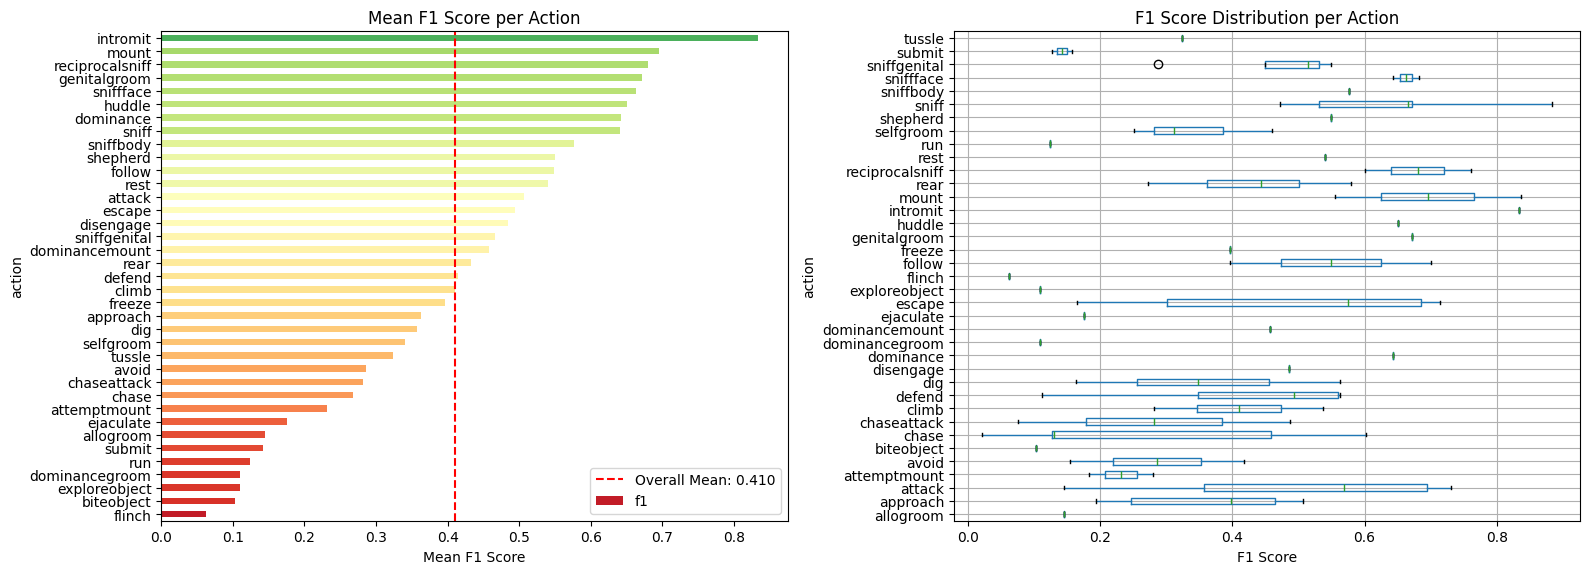


----------------------------------------
3. PREDICTION ANALYSIS
----------------------------------------

Unique actions in solution: 37
Unique actions in predictions: 37

Prediction vs Ground Truth counts:
                 True Count  Pred Count  Ratio
action                                        
sniff                 37837      182480   4.82
sniffgenital           7862       41713   5.31
attack                 7462       73206   9.81
rear                   4408       62643  14.21
sniffbody              3518       14733   4.19
approach               3270       18053   5.52
sniffface              2811        8544   3.04
mount                  2747       32521  11.84
escape                 2071       11117   5.37
reciprocalsniff        1492        4062   2.72
defend                 1409       15568  11.05
selfgroom              1356       29294  21.60
dig                    1127       21485  19.06
climb                  1010        9890   9.79
chase                   826       11572 

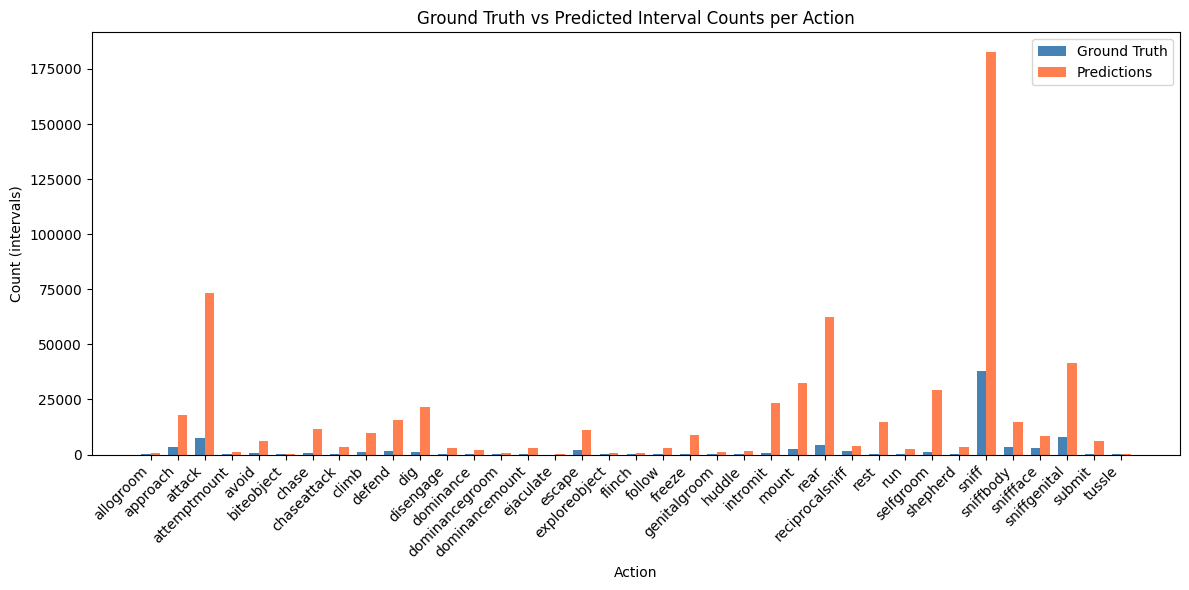


----------------------------------------
4. FRAME-LEVEL ANALYSIS
----------------------------------------

Frame-level metrics (sample of 10 videos):
             precision  recall      f1
action                                
rear            0.6914  0.6345  0.6617
approach        0.3769  0.4049  0.3904
avoid           0.3111  0.2994  0.3051
submit          0.2324  0.2723  0.2508
attack          0.2641  0.1987  0.2268
chase           0.1015  0.1425  0.1185
chaseattack     0.0590  0.1303  0.0812


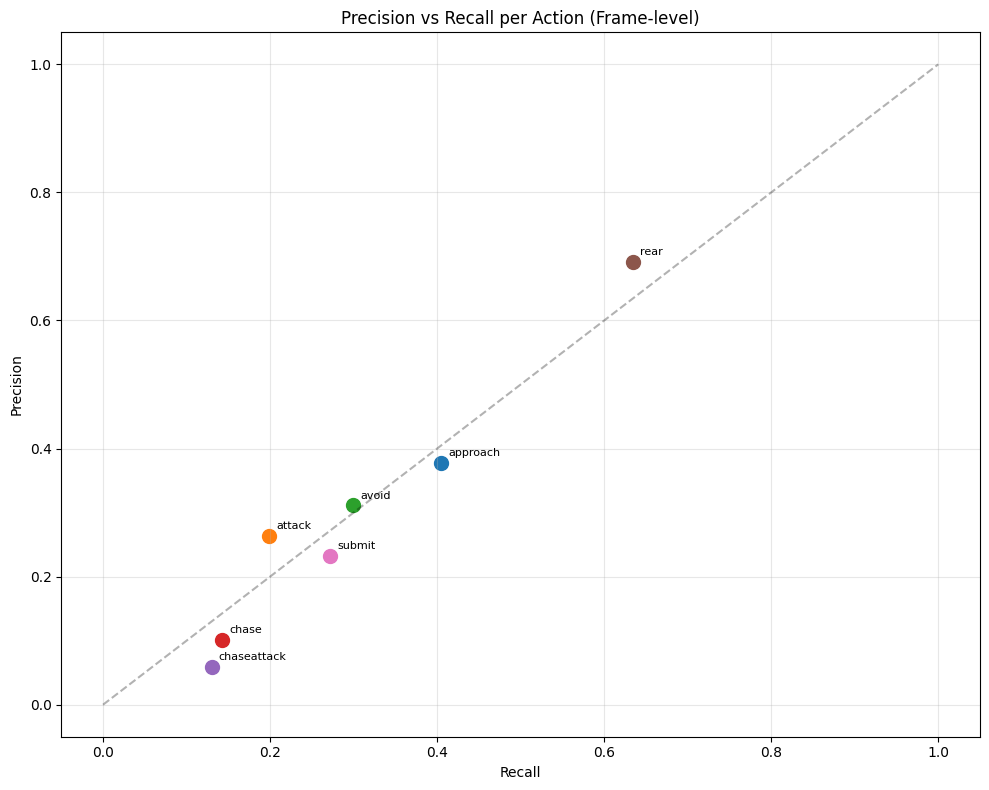


----------------------------------------
5. THRESHOLD ANALYSIS
----------------------------------------

Threshold statistics:
  Mean:   0.182
  Median: 0.185
  Std:    0.117
  Min:    0.010
  Max:    0.490

Per-action thresholds:
                  mean    std
action                       
tussle           0.010    NaN
ejaculate        0.010    NaN
dominancegroom   0.010    NaN
exploreobject    0.020    NaN
biteobject       0.020    NaN
flinch           0.020    NaN
submit           0.025  0.021
attemptmount     0.055  0.035
chaseattack      0.060  0.071
run              0.070    NaN
chase            0.072  0.054
avoid            0.125  0.064
climb            0.145  0.035
approach         0.155  0.088
selfgroom        0.160  0.046
allogroom        0.160    NaN
dig              0.167  0.076
dominance        0.180    NaN
rear             0.187  0.068
genitalgroom     0.190    NaN
defend           0.198  0.122
freeze           0.200    NaN
follow           0.210  0.156
huddle           0

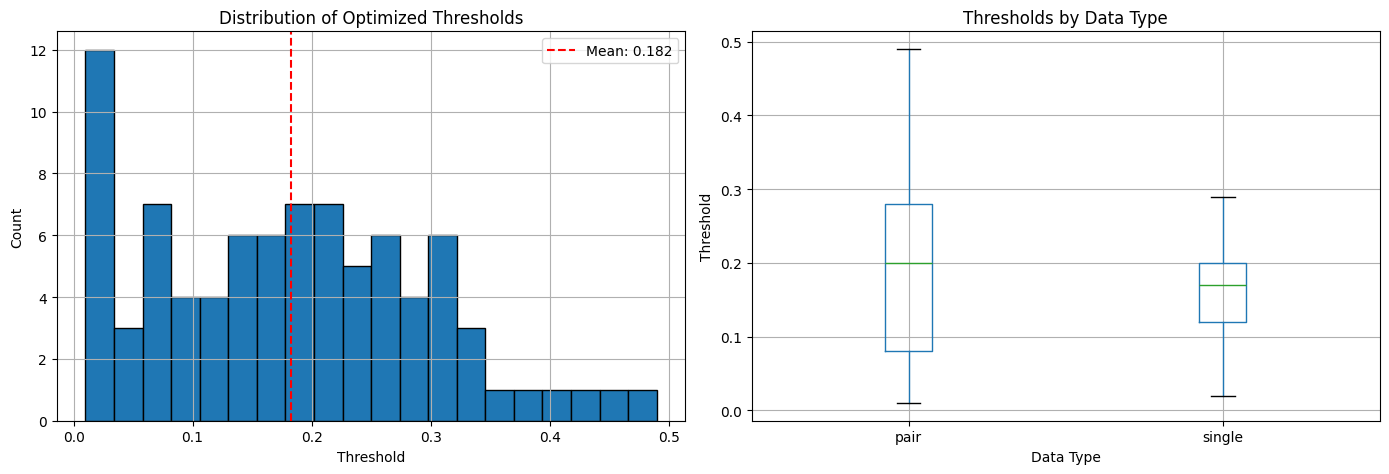


----------------------------------------
6. LAB-WISE PERFORMANCE
----------------------------------------

Per-lab F1 scores:
              lab_id  n_videos  n_annotations  n_predictions  f1_score
   ReflectiveManatee        20           1659           4930  0.837937
      SparklingTapir        54           1171           4792  0.695453
       CalMS21_task2        76           6336          36307  0.688823
       CalMS21_task1       101           7393          31562  0.642678
        UppityFerret        21           2161           7334  0.581833
CalMS21_supplemental       297          30868         157087  0.575433
    BoisterousParrot         8            201           3569  0.549639
         LyricalHare        24           1455          45468  0.516685
        DeliriousFly         6            811           4919  0.491089
              CRIM13        21           1792          33781  0.445030
     CautiousGiraffe        10           1099           5931  0.389960
      NiftyGoldfinch 

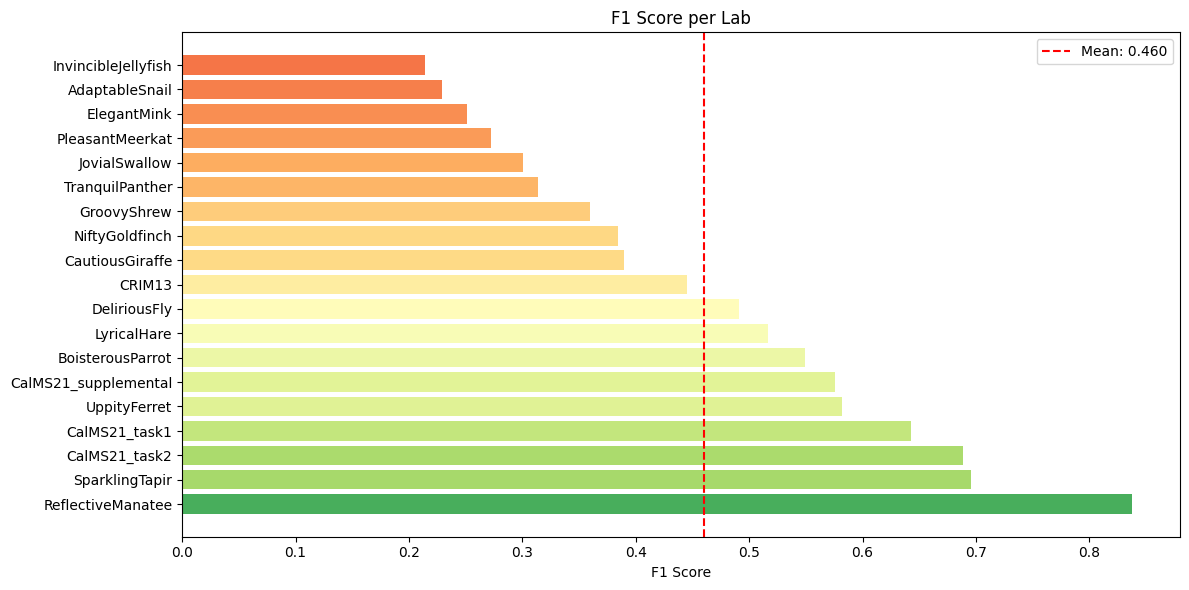


EVALUATION SUMMARY

📊 Competition F1 Score: 0.4600
📈 Mean Binary F1: 0.4294
🎯 Best Action: intromit (0.8330)
⚠️  Worst Action: flinch (0.0625)
🏆 Best Lab: ReflectiveManatee (0.8379)
📉 Worst Lab: InvincibleJellyfish (0.2145)

📁 Results saved to: /Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/models/xgboost/

✅ Evaluation complete!


In [32]:
# =============================================================================
# MODEL EVALUATION & VISUALIZATION
# =============================================================================

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc

print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# -----------------------------------------------------------------------------
# 1. OVERALL PERFORMANCE SUMMARY
# -----------------------------------------------------------------------------

if CFG.mode == 'validate' and 'f1_df' in dir():
    print("\n" + "-" * 40)
    print("1. OVERALL PERFORMANCE SUMMARY")
    print("-" * 40)
    
    # Summary statistics
    print(f"\nTotal actions trained: {f1_df['action'].nunique()}")
    print(f"Total models trained: {len(f1_df)}")
    print(f"\nF1 Score Statistics:")
    print(f"  Mean:   {f1_df['f1'].mean():.4f}")
    print(f"  Median: {f1_df['f1'].median():.4f}")
    print(f"  Std:    {f1_df['f1'].std():.4f}")
    print(f"  Min:    {f1_df['f1'].min():.4f}")
    print(f"  Max:    {f1_df['f1'].max():.4f}")

# -----------------------------------------------------------------------------
# 2. PER-ACTION PERFORMANCE
# -----------------------------------------------------------------------------

if CFG.mode == 'validate' and 'f1_df' in dir():
    print("\n" + "-" * 40)
    print("2. PER-ACTION PERFORMANCE")
    print("-" * 40)
    
    action_stats = f1_df.groupby('action')['f1'].agg(['mean', 'std', 'min', 'max', 'count']).round(4)
    action_stats = action_stats.sort_values('mean', ascending=False)
    print("\nAction-wise F1 scores:")
    print(action_stats.to_string())
    
    # Visualization: Bar plot of per-action F1 scores
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    ax1 = axes[0]
    action_means = f1_df.groupby('action')['f1'].mean().sort_values(ascending=True)
    colors = plt.cm.RdYlGn(action_means.values)
    action_means.plot(kind='barh', ax=ax1, color=colors)
    ax1.set_xlabel('Mean F1 Score')
    ax1.set_title('Mean F1 Score per Action')
    ax1.axvline(x=action_means.mean(), color='red', linestyle='--', label=f'Overall Mean: {action_means.mean():.3f}')
    ax1.legend()
    
    # Box plot
    ax2 = axes[1]
    f1_df.boxplot(column='f1', by='action', ax=ax2, vert=False)
    ax2.set_xlabel('F1 Score')
    ax2.set_title('F1 Score Distribution per Action')
    plt.suptitle('')  # Remove automatic title
    
    plt.tight_layout()
    plt.savefig(f"{CFG.model_output_path}/{CFG.model_name}/per_action_f1.png", dpi=150, bbox_inches='tight')
    plt.show()

# -----------------------------------------------------------------------------
# 3. CONFUSION MATRIX ANALYSIS (from submission vs solution)
# -----------------------------------------------------------------------------

if CFG.mode == 'validate' and 'solution' in dir() and 'submission_robust' in dir():
    print("\n" + "-" * 40)
    print("3. PREDICTION ANALYSIS")
    print("-" * 40)
    
    # Get all unique actions
    all_actions = sorted(set(solution['action'].unique()) | set(submission_robust['action'].unique()))
    print(f"\nUnique actions in solution: {len(solution['action'].unique())}")
    print(f"Unique actions in predictions: {len(submission_robust['action'].unique())}")
    
    # Count predictions per action
    pred_counts = submission_robust['action'].value_counts()
    true_counts = solution['action'].value_counts()
    
    # Combine into comparison DataFrame
    comparison_df = pd.DataFrame({
        'True Count': true_counts,
        'Pred Count': pred_counts
    }).fillna(0).astype(int)
    comparison_df['Ratio'] = (comparison_df['Pred Count'] / comparison_df['True Count'].replace(0, 1)).round(2)
    print("\nPrediction vs Ground Truth counts:")
    print(comparison_df.sort_values('True Count', ascending=False).to_string())
    
    # Visualization: Prediction counts comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(comparison_df))
    width = 0.35
    
    ax.bar(x - width/2, comparison_df['True Count'], width, label='Ground Truth', color='steelblue')
    ax.bar(x + width/2, comparison_df['Pred Count'], width, label='Predictions', color='coral')
    
    ax.set_xlabel('Action')
    ax.set_ylabel('Count (intervals)')
    ax.set_title('Ground Truth vs Predicted Interval Counts per Action')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(f"{CFG.model_output_path}/{CFG.model_name}/prediction_counts.png", dpi=150, bbox_inches='tight')
    plt.show()

# -----------------------------------------------------------------------------
# 4. FRAME-LEVEL CONFUSION MATRIX
# -----------------------------------------------------------------------------

if CFG.mode == 'validate' and 'solution' in dir() and 'submission_robust' in dir():
    print("\n" + "-" * 40)
    print("4. FRAME-LEVEL ANALYSIS")
    print("-" * 40)
    
    # Build frame-level predictions for a sample of videos
    sample_videos = solution['video_id'].unique()[:10]  # Analyze first 10 videos
    
    frame_results = []
    for video_id in sample_videos:
        video_sol = solution[solution['video_id'] == video_id]
        video_pred = submission_robust[submission_robust['video_id'] == video_id]
        
        if len(video_sol) == 0:
            continue
            
        # Get frame range
        max_frame = max(
            video_sol['stop_frame'].max() if len(video_sol) > 0 else 0,
            video_pred['stop_frame'].max() if len(video_pred) > 0 else 0
        )
        
        # Build frame-level arrays for each action
        for action in video_sol['action'].unique():
            true_frames = set()
            pred_frames = set()
            
            # Ground truth frames
            for _, row in video_sol[video_sol['action'] == action].iterrows():
                true_frames.update(range(int(row['start_frame']), int(row['stop_frame'])))
            
            # Predicted frames
            for _, row in video_pred[video_pred['action'] == action].iterrows():
                pred_frames.update(range(int(row['start_frame']), int(row['stop_frame'])))
            
            tp = len(true_frames & pred_frames)
            fp = len(pred_frames - true_frames)
            fn = len(true_frames - pred_frames)
            
            if tp + fp + fn > 0:
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                
                frame_results.append({
                    'video_id': video_id,
                    'action': action,
                    'true_frames': len(true_frames),
                    'pred_frames': len(pred_frames),
                    'tp': tp,
                    'fp': fp,
                    'fn': fn,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                })
    
    if frame_results:
        frame_df = pd.DataFrame(frame_results)
        
        # Aggregate by action
        action_frame_stats = frame_df.groupby('action').agg({
            'true_frames': 'sum',
            'pred_frames': 'sum',
            'tp': 'sum',
            'fp': 'sum',
            'fn': 'sum'
        })
        
        action_frame_stats['precision'] = action_frame_stats['tp'] / (action_frame_stats['tp'] + action_frame_stats['fp']).replace(0, 1)
        action_frame_stats['recall'] = action_frame_stats['tp'] / (action_frame_stats['tp'] + action_frame_stats['fn']).replace(0, 1)
        action_frame_stats['f1'] = 2 * action_frame_stats['precision'] * action_frame_stats['recall'] / (action_frame_stats['precision'] + action_frame_stats['recall']).replace(0, 1)
        
        print("\nFrame-level metrics (sample of 10 videos):")
        print(action_frame_stats[['precision', 'recall', 'f1']].round(4).sort_values('f1', ascending=False).to_string())
        
        # Visualization: Precision-Recall per action
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for action in action_frame_stats.index:
            ax.scatter(
                action_frame_stats.loc[action, 'recall'],
                action_frame_stats.loc[action, 'precision'],
                s=100,
                label=action
            )
            ax.annotate(
                action,
                (action_frame_stats.loc[action, 'recall'], action_frame_stats.loc[action, 'precision']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8
            )
        
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision vs Recall per Action (Frame-level)')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # Diagonal reference
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"{CFG.model_output_path}/{CFG.model_name}/precision_recall.png", dpi=150, bbox_inches='tight')
        plt.show()

# -----------------------------------------------------------------------------
# 5. THRESHOLD ANALYSIS
# -----------------------------------------------------------------------------

if CFG.mode == 'validate' and 'thresholds_all' in dir():
    print("\n" + "-" * 40)
    print("5. THRESHOLD ANALYSIS")
    print("-" * 40)
    
    # Collect all thresholds
    all_thresholds = []
    for data_type in ['single', 'pair']:
        for section, thresh_dict in thresholds_all.get(data_type, {}).items():
            for action, threshold in thresh_dict.items():
                all_thresholds.append({
                    'type': data_type,
                    'section': section,
                    'action': action,
                    'threshold': threshold
                })
    
    if all_thresholds:
        thresh_df = pd.DataFrame(all_thresholds)
        
        print("\nThreshold statistics:")
        print(f"  Mean:   {thresh_df['threshold'].mean():.3f}")
        print(f"  Median: {thresh_df['threshold'].median():.3f}")
        print(f"  Std:    {thresh_df['threshold'].std():.3f}")
        print(f"  Min:    {thresh_df['threshold'].min():.3f}")
        print(f"  Max:    {thresh_df['threshold'].max():.3f}")
        
        # Per-action threshold stats
        action_thresh = thresh_df.groupby('action')['threshold'].agg(['mean', 'std']).round(3)
        print("\nPer-action thresholds:")
        print(action_thresh.sort_values('mean').to_string())
        
        # Visualization: Threshold distribution
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        ax1 = axes[0]
        thresh_df['threshold'].hist(bins=20, ax=ax1, edgecolor='black')
        ax1.axvline(x=thresh_df['threshold'].mean(), color='red', linestyle='--', label=f"Mean: {thresh_df['threshold'].mean():.3f}")
        ax1.set_xlabel('Threshold')
        ax1.set_ylabel('Count')
        ax1.set_title('Distribution of Optimized Thresholds')
        ax1.legend()
        
        # Box plot by type
        ax2 = axes[1]
        thresh_df.boxplot(column='threshold', by='type', ax=ax2)
        ax2.set_xlabel('Data Type')
        ax2.set_ylabel('Threshold')
        ax2.set_title('Thresholds by Data Type')
        plt.suptitle('')
        
        plt.tight_layout()
        plt.savefig(f"{CFG.model_output_path}/{CFG.model_name}/threshold_analysis.png", dpi=150, bbox_inches='tight')
        plt.show()

# -----------------------------------------------------------------------------
# 6. LAB-WISE PERFORMANCE
# -----------------------------------------------------------------------------

if CFG.mode == 'validate' and 'solution' in dir() and 'submission_robust' in dir():
    print("\n" + "-" * 40)
    print("6. LAB-WISE PERFORMANCE")
    print("-" * 40)
    
    lab_scores = []
    for lab in solution['lab_id'].unique():
        lab_solution = solution[solution['lab_id'] == lab]
        lab_videos = set(lab_solution['video_id'].unique())
        lab_submission = submission_robust[submission_robust['video_id'].isin(lab_videos)]
        
        if len(lab_solution) > 0 and len(lab_submission) > 0:
            lab_score = single_lab_f1(lab_solution, lab_submission, beta=1)
            lab_scores.append({
                'lab_id': lab,
                'n_videos': len(lab_videos),
                'n_annotations': len(lab_solution),
                'n_predictions': len(lab_submission),
                'f1_score': lab_score
            })
    
    if lab_scores:
        lab_df = pd.DataFrame(lab_scores).sort_values('f1_score', ascending=False)
        print("\nPer-lab F1 scores:")
        print(lab_df.to_string(index=False))
        
        # Visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        colors = plt.cm.RdYlGn(lab_df['f1_score'].values)
        bars = ax.barh(lab_df['lab_id'], lab_df['f1_score'], color=colors)
        ax.set_xlabel('F1 Score')
        ax.set_title('F1 Score per Lab')
        ax.axvline(x=lab_df['f1_score'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {lab_df['f1_score'].mean():.3f}")
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f"{CFG.model_output_path}/{CFG.model_name}/lab_performance.png", dpi=150, bbox_inches='tight')
        plt.show()

# -----------------------------------------------------------------------------
# 7. SUMMARY REPORT
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)

if CFG.mode == 'validate' and 'score' in dir():
    print(f"\n📊 Competition F1 Score: {score:.4f}")
    if 'f1_df' in dir():
        print(f"📈 Mean Binary F1: {f1_df['f1'].mean():.4f}")
        print(f"🎯 Best Action: {f1_df.groupby('action')['f1'].mean().idxmax()} ({f1_df.groupby('action')['f1'].mean().max():.4f})")
        print(f"⚠️  Worst Action: {f1_df.groupby('action')['f1'].mean().idxmin()} ({f1_df.groupby('action')['f1'].mean().min():.4f})")
    if 'lab_df' in dir():
        print(f"🏆 Best Lab: {lab_df.iloc[0]['lab_id']} ({lab_df.iloc[0]['f1_score']:.4f})")
        print(f"📉 Worst Lab: {lab_df.iloc[-1]['lab_id']} ({lab_df.iloc[-1]['f1_score']:.4f})")
    print(f"\n📁 Results saved to: {CFG.model_output_path}/{CFG.model_name}/")

print("\n✅ Evaluation complete!")

In [ ]:
print("TEST DATA OVERVIEW")
print("=" * 60)
print(f"Shape: {test_df.shape}")
print(f"\nNumber of test videos: {len(test_df)}")
print(f"Unique labs in test: {test_df['lab_id'].nunique()}")
print(f"\nLabs in test set:")
print(test_df['lab_id'].value_counts())

print(f"\nBody part configurations in test:")
print(test_df['body_parts_tracked'].value_counts())

# Check if test tracking files exist
import os
sample_test = test_df.iloc[0]
test_path = f"{CFG.test_tracking_path}/{sample_test['lab_id']}/{sample_test['video_id']}.parquet"
print(f"\nSample test tracking file exists: {os.path.exists(test_path)}")

# Load and display first 10 rows of test tracking data
if os.path.exists(test_path):
    print(f"\n" + "=" * 60)
    print("SAMPLE TEST TRACKING DATA")
    print("=" * 60)
    print(f"File: {test_path}")
    
    test_tracking_sample = pd.read_parquet(test_path)
    print(f"\nShape: {test_tracking_sample.shape}")
    print(f"Columns: {test_tracking_sample.columns.tolist()}")
    print(f"\nUnique mouse IDs: {test_tracking_sample['mouse_id'].unique()}")
    print(f"Unique body parts: {test_tracking_sample['bodypart'].nunique()}")
    print(f"Frame range: {test_tracking_sample['video_frame'].min()} - {test_tracking_sample['video_frame'].max()}")
    
    print(f"\nFirst 10 rows:")
    display(test_tracking_sample.head(10))
else:
    print("\n⚠️ Test tracking file not found!")

print('DONE')

TEST DATA OVERVIEW
Shape: (1, 38)

Number of test videos: 1
Unique labs in test: 1

Labs in test set:
lab_id
AdaptableSnail    1
Name: count, dtype: int64

Body part configurations in test:
body_parts_tracked
["body_center", "ear_left", "ear_right", "headpiece_bottombackleft", "headpiece_bottombackright", "headpiece_bottomfrontleft", "headpiece_bottomfrontright", "headpiece_topbackleft", "headpiece_topbackright", "headpiece_topfrontleft", "headpiece_topfrontright", "lateral_left", "lateral_right", "neck", "nose", "tail_base", "tail_midpoint", "tail_tip"]    1
Name: count, dtype: int64

Sample test tracking file exists: True

SAMPLE TEST TRACKING DATA
File: /Users/amin/Desktop/Machine Learning/Github/MABe-Challenge-2025/data/test_tracking/AdaptableSnail/438887472.parquet

Shape: (1089866, 5)
Columns: ['video_frame', 'mouse_id', 'bodypart', 'x', 'y']

Unique mouse IDs: [1 2 3 4]
Unique body parts: 18
Frame range: 0 - 18422

First 10 rows:


,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,909.577026,960.265991
1,0,1,ear_left,861.718018,988.614014
2,0,1,ear_right,882.953003,934.760010
3,0,1,headpiece_bottombackright,828.593994,997.226013
4,0,1,headpiece_bottomfrontleft,843.098022,948.182983
5,0,1,headpiece_bottomfrontright,839.138977,945.927002
6,0,1,headpiece_topbackleft,812.976990,1002.202026
7,0,1,headpiece_topbackright,812.216980,995.581970
8,0,1,headpiece_topfrontleft,819.119995,941.216003
9,0,1,headpiece_topfrontright,821.611023,942.671021
